# TFT Hyperparameter Tuning Results Analysis

This notebook provides a comprehensive analysis of all TFT (Temporal Fusion Transformer) experiments run using Optuna for Henry Hub natural gas price prediction.

## Contents
1. **Setup & Imports** — Load libraries and configure environment
2. **Load Experiment Data** — Load trial summaries and best parameters
3. **Experiment Overview** — Summary statistics for each experiment
4. **Pruning Analysis** — Pruning rates and efficiency per experiment
5. **Best Model Comparison** — Metrics comparison across experiments
6. **Hyperparameter Distributions** — Parameter value distributions
7. **Hyperparameter Impact Analysis** — Parameter effects on performance
8. **Cross-Experiment Parameter Comparison** — What works best overall
9. **Optimization Convergence** — Convergence analysis over trials
10. **Re-Train Best Models** — Regenerate predictions for experiments without saved outputs
11. **Prediction Visualizations** — Actual vs predicted plots for best models
12. **Correlation Analysis** — Hyperparameter correlations with performance
13. **Radar Chart Comparison** — Multi-metric visual comparison
14. **Final Summary & Recommendations** — Key findings and optimal configurations
15. **Export Summary Tables** — Save CSVs for thesis

### Experiments Analysed:
- **Price Only** — Univariate model using only historical prices
- **Price + Storage** — Prices with gas storage levels
- **Price + Production** — Prices with US dry gas production
- **Price + USD** — Prices with USD index
- **Price + Weather** — Prices with HDD/CDD weather data
- **All Features** — All features combined

In [1]:
# === Cell 1: Setup and Imports ===
import os
import json
import ast
import datetime
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from math import pi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Install seaborn if not available
try:
    import seaborn as sns
except ImportError:
    %pip install seaborn
    import seaborn as sns

warnings.filterwarnings('ignore')

# Plotting defaults
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 10
sns.set_style("whitegrid")

# Color palette for experiments (same as LSTM for consistency)
EXPERIMENT_COLORS = {
    "Price Only": "#1f77b4",
    "Price + Storage": "#ff7f0e", 
    "Price + Production": "#2ca02c",
    "Price + USD": "#d62728",
    "Price + Weather": "#9467bd",
    "All Features": "#8c564b"
}

# Directory paths
SAVED_RESULTS_DIR = Path("saved_results")

print("✅ Libraries loaded successfully")
print(f"📂 Results directory: {SAVED_RESULTS_DIR.absolute()}")

✅ Libraries loaded successfully
📂 Results directory: /Users/adam/Documents/CS310 - 3rd Year Project/Baseline TFT Model/saved_results


## 1. Load All Experiment Data

Define paths to each experiment's trial summary CSV and load the data.

In [2]:
# === Cell 2: Define Experiment Paths and Load Data ===

# Auto-discover TFT experiment folders
def discover_tft_experiments(base_dir: Path) -> Dict[str, str]:
    """Automatically discover TFT experiment folders."""
    experiments = {}
    if not base_dir.exists():
        print(f"⚠️ Directory not found: {base_dir}")
        return experiments
    
    # Map folder patterns to experiment names
    name_mapping = {
        "PriceOnly_tft": "Price Only",
        "Price+Storage_tft": "Price + Storage",
        "Price+Production_tft": "Price + Production",
        "Price+USD_tft": "Price + USD",
        "Price+Weather_tft": "Price + Weather",
        "AllFeatures_tft": "All Features",
    }
    
    for folder in sorted(base_dir.iterdir()):
        if folder.is_dir() and "_tft" in folder.name:
            for pattern, name in name_mapping.items():
                if pattern in folder.name:
                    # Keep most recent folder for each experiment
                    if name not in experiments or folder.name > experiments[name]:
                        experiments[name] = folder.name
                    break
    
    return experiments

def load_trial_summary(experiment_dir: Path) -> Optional[pd.DataFrame]:
    """Load trial_summary.csv and parse the params JSON column."""
    csv_path = experiment_dir / "trial_summary.csv"
    if not csv_path.exists():
        print(f"⚠️ Not found: {csv_path}")
        return None
    
    df = pd.read_csv(csv_path)
    
    # Parse params column from JSON string to dict
    # Use json.loads instead of ast.literal_eval to handle JSON booleans (true/false)
    if 'params' in df.columns:
        df['params_dict'] = df['params'].apply(lambda x: json.loads(x) if pd.notna(x) else {})
        
        # Extract individual TFT hyperparameters
        df['lookback'] = df['params_dict'].apply(lambda x: x.get('max_encoder_length'))
        df['batch_size'] = df['params_dict'].apply(lambda x: x.get('batch_size'))
        df['hidden_size'] = df['params_dict'].apply(lambda x: x.get('hidden_size'))
        df['attention_head_size'] = df['params_dict'].apply(lambda x: x.get('attention_head_size'))
        df['hidden_continuous_size'] = df['params_dict'].apply(lambda x: x.get('hidden_continuous_size'))
        df['dropout'] = df['params_dict'].apply(lambda x: x.get('dropout'))
        df['lstm_layers'] = df['params_dict'].apply(lambda x: x.get('lstm_layers'))
        df['lr'] = df['params_dict'].apply(lambda x: x.get('learning_rate'))
        df['gradient_clip_val'] = df['params_dict'].apply(lambda x: x.get('gradient_clip_val'))
        df['weight_decay'] = df['params_dict'].apply(lambda x: x.get('weight_decay', 0.0))
    
    return df

def load_best_params(experiment_dir: Path) -> Optional[dict]:
    """Load best_params.json from experiment directory."""
    json_path = experiment_dir / "best_params.json"
    if not json_path.exists():
        return None
    with open(json_path, 'r') as f:
        return json.load(f)

def load_final_metrics(experiment_dir: Path) -> Optional[dict]:
    """Load final_test_metrics.json (contains y_true and y_pred)."""
    json_path = experiment_dir / "final_test_metrics.json"
    if not json_path.exists():
        return None
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Extract test_metrics if nested
    if 'test_metrics' in data:
        test_metrics = data['test_metrics']
        return {
            'best_val_loss': data.get('best_val_loss'),
            'y_true': np.array(test_metrics.get('y_true', [])),
            'y_pred_p50': np.array(test_metrics.get('y_pred_p50', [])),
            'MAE': test_metrics.get('MAE'),
            'RMSE': test_metrics.get('RMSE'),
            'MAPE': test_metrics.get('MAPE'),
            'Directional_Accuracy': test_metrics.get('Directional_Accuracy')
        }
    return data

# Discover experiments
EXPERIMENTS = discover_tft_experiments(SAVED_RESULTS_DIR)
print(f"🔍 Discovered TFT experiments:")
for name, folder in EXPERIMENTS.items():
    print(f"   • {name}: {folder}")

# Load all experiments
experiment_data = {}
best_params_data = {}
final_metrics_data = {}

for name, folder in EXPERIMENTS.items():
    exp_path = SAVED_RESULTS_DIR / folder
    
    # Load trial summary
    df = load_trial_summary(exp_path)
    if df is not None:
        experiment_data[name] = df
        print(f"✅ Loaded {name}: {len(df)} trials")
    
    # Load best params
    bp = load_best_params(exp_path)
    if bp is not None:
        best_params_data[name] = bp
    
    # Load final metrics (y_true, y_pred) - only if exists
    fm = load_final_metrics(exp_path)
    if fm is not None:
        final_metrics_data[name] = fm
        print(f"   └─ Has saved predictions ✓")

print(f"\n📊 Summary:")
print(f"   Total experiments loaded: {len(experiment_data)}")
print(f"   Best params available: {len(best_params_data)}")
print(f"   Final metrics (with predictions): {len(final_metrics_data)}")

# Check which experiments need retraining
experiments_needing_retrain = [name for name in experiment_data.keys() if name not in final_metrics_data]
if experiments_needing_retrain:
    print(f"\n⚠️ Experiments needing retraining to generate predictions:")
    for name in experiments_needing_retrain:
        print(f"   • {name}")

🔍 Discovered TFT experiments:
   • Price + Production: 20260114-055003_Price+Production_tft
   • Price Only: 20260114-055003_PriceOnly_tft
   • Price + Weather: 20260114-115928_Price+Weather_tft
   • All Features: 20260114-131952_AllFeatures_tft
   • Price + Storage: 20260114-181743_Price+Storage_tft
   • Price + USD: 20260114-195248_Price+USD_tft
✅ Loaded Price + Production: 300 trials
✅ Loaded Price Only: 300 trials
   └─ Has saved predictions ✓
✅ Loaded Price + Weather: 300 trials
✅ Loaded All Features: 300 trials
✅ Loaded Price + Storage: 300 trials
✅ Loaded Price + USD: 300 trials

📊 Summary:
   Total experiments loaded: 6
   Best params available: 6
   Final metrics (with predictions): 1

⚠️ Experiments needing retraining to generate predictions:
   • Price + Production
   • Price + Weather
   • All Features
   • Price + Storage
   • Price + USD


## 2. Experiment Overview & Summary Statistics

Summary of each experiment including total trials, completion rates, and basic statistics.

In [3]:
# === Cell 3: Generate Experiment Summary Statistics ===

def get_experiment_summary(df: pd.DataFrame, name: str) -> dict:
    """Extract summary statistics for an experiment."""
    total_trials = len(df)
    completed = df[df['state'] == 'COMPLETE']
    pruned = df[df['state'] == 'PRUNED']
    
    if len(completed) > 0:
        best_val_loss = completed['value'].min()
        mean_val_loss = completed['value'].mean()
        std_val_loss = completed['value'].std()
        
        best_idx = completed['value'].idxmin()
        test_mae = completed.loc[best_idx, 'test_mae'] if 'test_mae' in df.columns else None
        test_rmse = completed.loc[best_idx, 'test_rmse'] if 'test_rmse' in df.columns else None
        test_mape = completed.loc[best_idx, 'test_mape'] if 'test_mape' in df.columns else None
        test_da = completed.loc[best_idx, 'test_directional_accuracy'] if 'test_directional_accuracy' in df.columns else None
    else:
        best_val_loss = mean_val_loss = std_val_loss = None
        test_mae = test_rmse = test_mape = test_da = None
    
    return {
        'Experiment': name,
        'Total Trials': total_trials,
        'Completed': len(completed),
        'Pruned': len(pruned),
        'Completion Rate (%)': round(len(completed) / total_trials * 100, 1) if total_trials > 0 else 0,
        'Pruning Rate (%)': round(len(pruned) / total_trials * 100, 1) if total_trials > 0 else 0,
        'Best Val Loss': round(best_val_loss, 6) if best_val_loss else None,
        'Mean Val Loss': round(mean_val_loss, 4) if mean_val_loss else None,
        'Std Val Loss': round(std_val_loss, 4) if std_val_loss else None,
        'Best Test MAE': round(test_mae, 4) if test_mae and not pd.isna(test_mae) else None,
        'Best Test RMSE': round(test_rmse, 4) if test_rmse and not pd.isna(test_rmse) else None,
        'Best Test MAPE (%)': round(test_mape, 2) if test_mape and not pd.isna(test_mape) else None,
        'Best Test DA (%)': round(test_da, 2) if test_da and not pd.isna(test_da) else None
    }

# Generate summary for all experiments
summary_rows = []
for name, df in experiment_data.items():
    summary_rows.append(get_experiment_summary(df, name))

summary_df = pd.DataFrame(summary_rows)
print("=" * 100)
print("EXPERIMENT SUMMARY OVERVIEW")
print("=" * 100)
display(summary_df)

# Print aggregate stats
total_trials_all = summary_df['Total Trials'].sum()
total_completed_all = summary_df['Completed'].sum()
total_pruned_all = summary_df['Pruned'].sum()
print(f"\n📈 Aggregate Statistics:")
print(f"   Total trials across all experiments: {total_trials_all}")
print(f"   Total completed: {total_completed_all} ({total_completed_all/total_trials_all*100:.1f}%)")
print(f"   Total pruned: {total_pruned_all} ({total_pruned_all/total_trials_all*100:.1f}%)")

EXPERIMENT SUMMARY OVERVIEW


,Experiment,Total Trials,Completed,Pruned,Completion Rate (%),Pruning Rate (%),Best Val Loss,Mean Val Loss,Std Val Loss,Best Test MAE,Best Test RMSE,Best Test MAPE (%),Best Test DA (%)
0,Price + Production,300,103,197,34.3,65.7,0.234777,0.2995,0.0401,0.2020,0.6067,6.75,44.03
1,Price Only,300,187,113,62.3,37.7,0.245121,0.2997,0.0331,0.1805,0.6397,5.77,45.17
2,Price + Weather,300,125,175,41.7,58.3,0.234662,0.2898,0.0373,0.1804,0.6193,5.79,44.68
3,All Features,300,132,168,44.0,56.0,0.204424,0.2913,0.0560,0.1894,0.6232,6.40,45.17
4,Price + Storage,300,119,181,39.7,60.3,0.234566,0.2866,0.0380,0.1796,0.5787,5.99,44.84
5,Price + USD,300,137,163,45.7,54.3,0.231281,0.2857,0.0346,0.1769,0.5837,5.66,45.17



📈 Aggregate Statistics:
   Total trials across all experiments: 1800
   Total completed: 803 (44.6%)
   Total pruned: 997 (55.4%)


## 3. Pruning Analysis

Analyze pruning rates and efficiency across experiments.

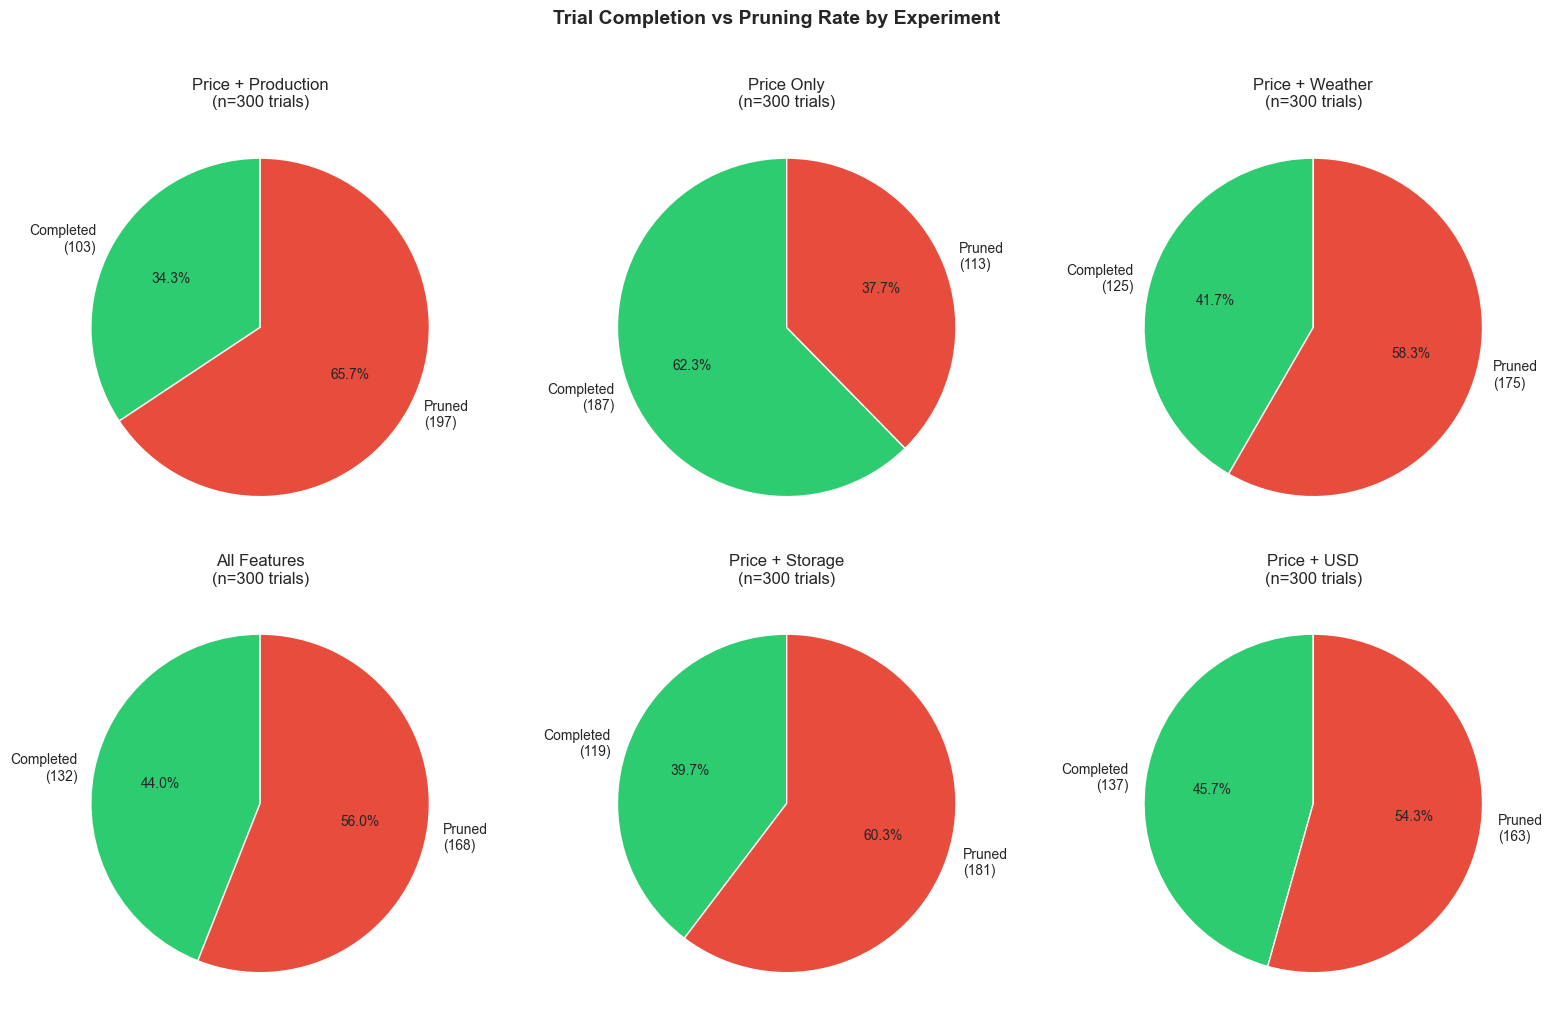


PRUNING ANALYSIS
⚠️ No pruned_epoch data available - TFT pruning may not record epoch information


,Experiment,Total Trials,Completed,Pruned,Pruning Rate (%)
0,Price + Production,300,103,197,65.7
1,Price Only,300,187,113,37.7
2,Price + Weather,300,125,175,58.3
3,All Features,300,132,168,56.0
4,Price + Storage,300,119,181,60.3
5,Price + USD,300,137,163,54.3


In [4]:
# === Cell 4: Pruning Analysis ===

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, df) in enumerate(experiment_data.items()):
    if idx >= len(axes):
        break
    ax = axes[idx]
    
    pruned_df = df[df['state'] == 'PRUNED'].copy()
    completed_df = df[df['state'] == 'COMPLETE'].copy()
    
    # Create pie chart
    sizes = [len(completed_df), len(pruned_df)]
    labels = [f'Completed\n({len(completed_df)})', f'Pruned\n({len(pruned_df)})']
    colors = ['#2ecc71', '#e74c3c']
    
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title(f'{name}\n(n={len(df)} trials)')

# Hide unused axes
for idx in range(len(experiment_data), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Trial Completion vs Pruning Rate by Experiment', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(SAVED_RESULTS_DIR / 'tft_pruning_pie_charts.png', dpi=150, bbox_inches='tight')
plt.show()

# Pruning epoch distribution (if available)
print("\n" + "=" * 80)
print("PRUNING ANALYSIS")
print("=" * 80)

# Check if any experiment has pruned_epoch data
has_pruning_epochs = False
for name, df in experiment_data.items():
    pruned_df = df[df['state'] == 'PRUNED']
    if 'pruned_epoch' in df.columns:
        pruned_epochs = pruned_df['pruned_epoch'].dropna()
        if len(pruned_epochs) > 0:
            has_pruning_epochs = True
            break

if has_pruning_epochs:
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, (name, df) in enumerate(experiment_data.items()):
        if idx >= len(axes):
            break
        ax = axes[idx]
        
        pruned_df = df[df['state'] == 'PRUNED'].copy()
        
        if 'pruned_epoch' in df.columns and len(pruned_df) > 0:
            pruned_epochs = pruned_df['pruned_epoch'].dropna()
            if len(pruned_epochs) > 0:
                ax.hist(pruned_epochs, bins=range(0, int(pruned_epochs.max()) + 2), 
                       color=EXPERIMENT_COLORS.get(name, '#333'), edgecolor='white', alpha=0.8)
                ax.axvline(pruned_epochs.mean(), color='red', linestyle='--', 
                          label=f'Mean: {pruned_epochs.mean():.1f}')
                ax.legend()
        
        ax.set_title(name)
        ax.set_xlabel('Epoch Pruned')
        ax.set_ylabel('Count')
    
    for idx in range(len(experiment_data), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Distribution of Pruning Epochs', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(SAVED_RESULTS_DIR / 'tft_pruning_epochs.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ No pruned_epoch data available - TFT pruning may not record epoch information")
    
    # Show pruning summary table instead
    pruning_summary = []
    for name, df in experiment_data.items():
        pruned = df[df['state'] == 'PRUNED']
        completed = df[df['state'] == 'COMPLETE']
        pruning_summary.append({
            'Experiment': name,
            'Total Trials': len(df),
            'Completed': len(completed),
            'Pruned': len(pruned),
            'Pruning Rate (%)': round(len(pruned) / len(df) * 100, 1) if len(df) > 0 else 0
        })
    
    pruning_df = pd.DataFrame(pruning_summary)
    display(pruning_df)

## 4. Best Model Comparison

Compare the best models from each experiment using key metrics.

BEST MODEL FROM EACH EXPERIMENT


,Experiment,Trial #,Val Loss,Test MAE,Test RMSE,Test MAPE (%),Directional Acc (%),Lookback,Batch Size,Hidden Size,Attention Heads,LSTM Layers,Dropout,Learning Rate
0,Price + Production,232,0.234777,0.202017,0.606672,6.751968,44.026187,180,32,64,2,3,0.086384,0.002987
1,Price Only,236,0.245121,0.180489,0.639722,5.773773,45.171849,180,32,192,2,1,0.059904,0.001844
2,Price + Weather,234,0.234662,0.180399,0.619340,5.790444,44.680851,90,32,192,8,1,0.131465,0.000797
3,All Features,230,0.204424,0.189440,0.623196,6.400562,45.171849,20,32,128,8,2,0.055503,0.002826
4,Price + Storage,204,0.234566,0.179591,0.578704,5.986441,44.844517,30,32,128,8,2,0.154397,0.002345
5,Price + USD,280,0.231281,0.176885,0.583653,5.657578,45.171849,30,32,128,8,2,0.092332,0.001996


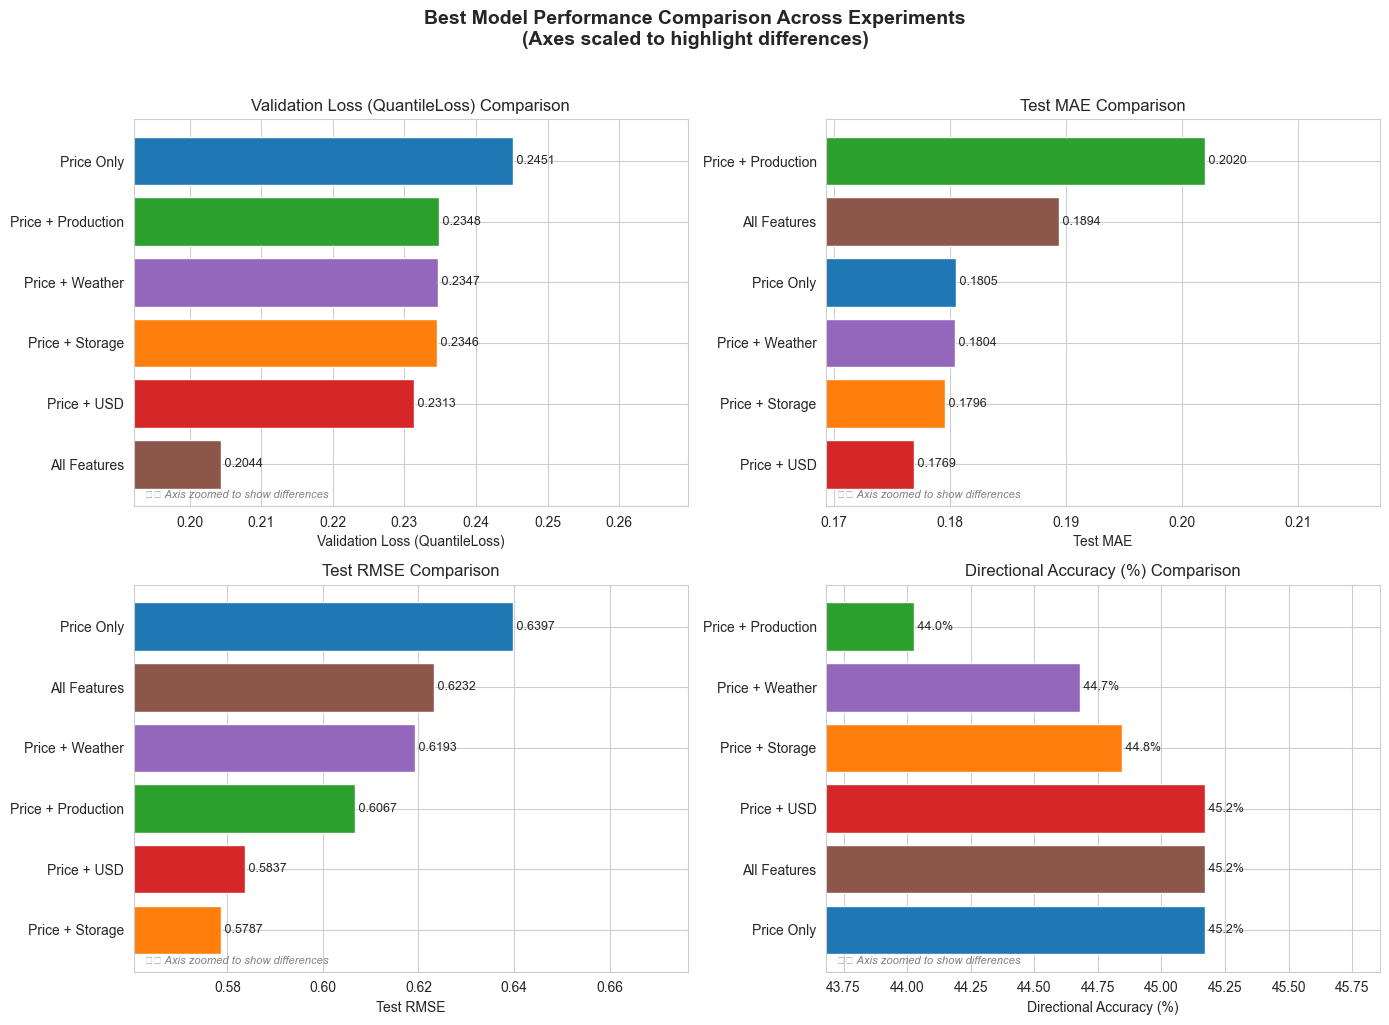


RELATIVE PERFORMANCE (% difference from best)


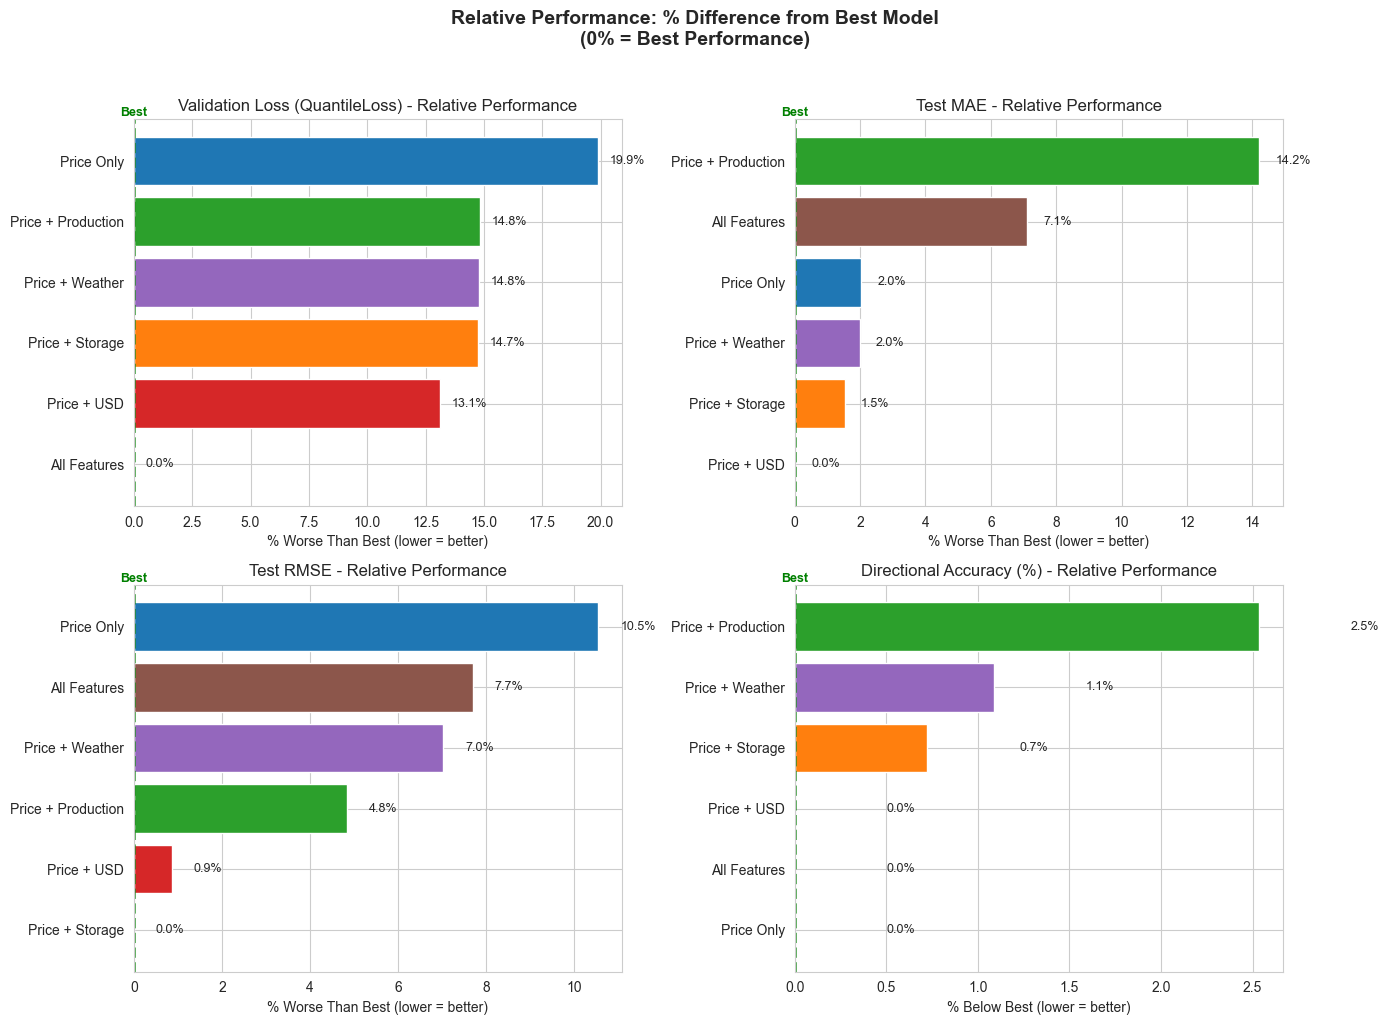

In [5]:
# === Cell 5: Best Model Comparison ===

def get_best_model_metrics(df: pd.DataFrame, name: str) -> Optional[dict]:
    """Get metrics for the best model (lowest val loss)."""
    completed = df[df['state'] == 'COMPLETE'].copy()
    if len(completed) == 0:
        return None
    
    best_idx = completed['value'].idxmin()
    best = completed.loc[best_idx]
    
    return {
        'Experiment': name,
        'Trial #': int(best['trial_number']),
        'Val Loss': best['value'],
        'Test MAE': best.get('test_mae'),
        'Test RMSE': best.get('test_rmse'),
        'Test MAPE (%)': best.get('test_mape'),
        'Directional Acc (%)': best.get('test_directional_accuracy'),
        'Lookback': int(best.get('lookback')) if pd.notna(best.get('lookback')) else None,
        'Batch Size': int(best.get('batch_size')) if pd.notna(best.get('batch_size')) else None,
        'Hidden Size': int(best.get('hidden_size')) if pd.notna(best.get('hidden_size')) else None,
        'Attention Heads': int(best.get('attention_head_size')) if pd.notna(best.get('attention_head_size')) else None,
        'LSTM Layers': int(best.get('lstm_layers')) if pd.notna(best.get('lstm_layers')) else None,
        'Dropout': best.get('dropout'),
        'Learning Rate': best.get('lr')
    }

# Collect best models
best_models = []
for name, df in experiment_data.items():
    result = get_best_model_metrics(df, name)
    if result:
        best_models.append(result)

best_df = pd.DataFrame(best_models)

print("=" * 100)
print("BEST MODEL FROM EACH EXPERIMENT")
print("=" * 100)
display(best_df)

# Create comparison bar charts with ZOOMED axes to show differences
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = [
    ('Val Loss', 'Validation Loss (QuantileLoss)', True),  # lower is better
    ('Test MAE', 'Test MAE', True),
    ('Test RMSE', 'Test RMSE', True),
    ('Directional Acc (%)', 'Directional Accuracy (%)', False)  # higher is better
]

for ax, (col, title, lower_better) in zip(axes.flatten(), metrics):
    data = best_df[['Experiment', col]].dropna()
    if len(data) == 0:
        ax.text(0.5, 0.5, f'No data for {col}', ha='center', va='center', transform=ax.transAxes)
        continue
    
    # Sort appropriately
    data_sorted = data.sort_values(col, ascending=lower_better)
    
    colors = [EXPERIMENT_COLORS.get(exp, '#333') for exp in data_sorted['Experiment']]
    bars = ax.barh(data_sorted['Experiment'], data_sorted[col], color=colors)
    
    ax.set_xlabel(title)
    ax.set_title(f'{title} Comparison')
    
    # Add value labels
    for bar, val in zip(bars, data_sorted[col]):
        ax.text(val, bar.get_y() + bar.get_height()/2, 
               f' {val:.4f}' if col != 'Directional Acc (%)' else f' {val:.1f}%',
               va='center', ha='left', fontsize=9)
    
    # === ZOOM IN on the data range to show differences ===
    data_min = data_sorted[col].min()
    data_max = data_sorted[col].max()
    data_range = data_max - data_min
    
    if data_range > 0:
        padding = data_range * 0.3
        ax.set_xlim(max(0, data_min - padding), data_max + padding * 2)
    
    ax.annotate('⚠️ Axis zoomed to show differences', 
                xy=(0.02, 0.02), xycoords='axes fraction',
                fontsize=8, color='gray', style='italic')

plt.suptitle('Best Model Performance Comparison Across Experiments\n(Axes scaled to highlight differences)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(SAVED_RESULTS_DIR / 'tft_best_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# === ADDITIONAL: Relative Performance Chart (% worse than best) ===
print("\n" + "=" * 80)
print("RELATIVE PERFORMANCE (% difference from best)")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, (col, title, lower_better) in zip(axes.flatten(), metrics):
    data = best_df[['Experiment', col]].dropna().copy()
    if len(data) == 0:
        ax.text(0.5, 0.5, f'No data for {col}', ha='center', va='center', transform=ax.transAxes)
        continue
    
    # Calculate relative performance
    if lower_better:
        best_val = data[col].min()
        data['relative'] = ((data[col] - best_val) / best_val) * 100
        ylabel = '% Worse Than Best (lower = better)'
    else:
        best_val = data[col].max()
        data['relative'] = ((best_val - data[col]) / best_val) * 100
        ylabel = '% Below Best (lower = better)'
    
    data_sorted = data.sort_values('relative', ascending=True)
    colors = [EXPERIMENT_COLORS.get(exp, '#333') for exp in data_sorted['Experiment']]
    bars = ax.barh(data_sorted['Experiment'], data_sorted['relative'], color=colors)
    
    ax.set_xlabel(ylabel)
    ax.set_title(f'{title} - Relative Performance')
    
    for bar, val in zip(bars, data_sorted['relative']):
        label_x = val + 0.5 if val >= 0 else val - 0.5
        ax.text(label_x, bar.get_y() + bar.get_height()/2, 
               f'{val:.1f}%', va='center', ha='left' if val >= 0 else 'right', fontsize=9)
    
    ax.axvline(x=0, color='green', linestyle='--', linewidth=2, alpha=0.7)
    ax.annotate('Best', xy=(0, ax.get_ylim()[1]), ha='center', va='bottom', 
                color='green', fontsize=9, fontweight='bold')

plt.suptitle('Relative Performance: % Difference from Best Model\n(0% = Best Performance)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(SAVED_RESULTS_DIR / 'tft_relative_performance.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Hyperparameter Distribution Analysis

Analyze the distribution of hyperparameters across completed trials.

📊 Combined completed trials: 803


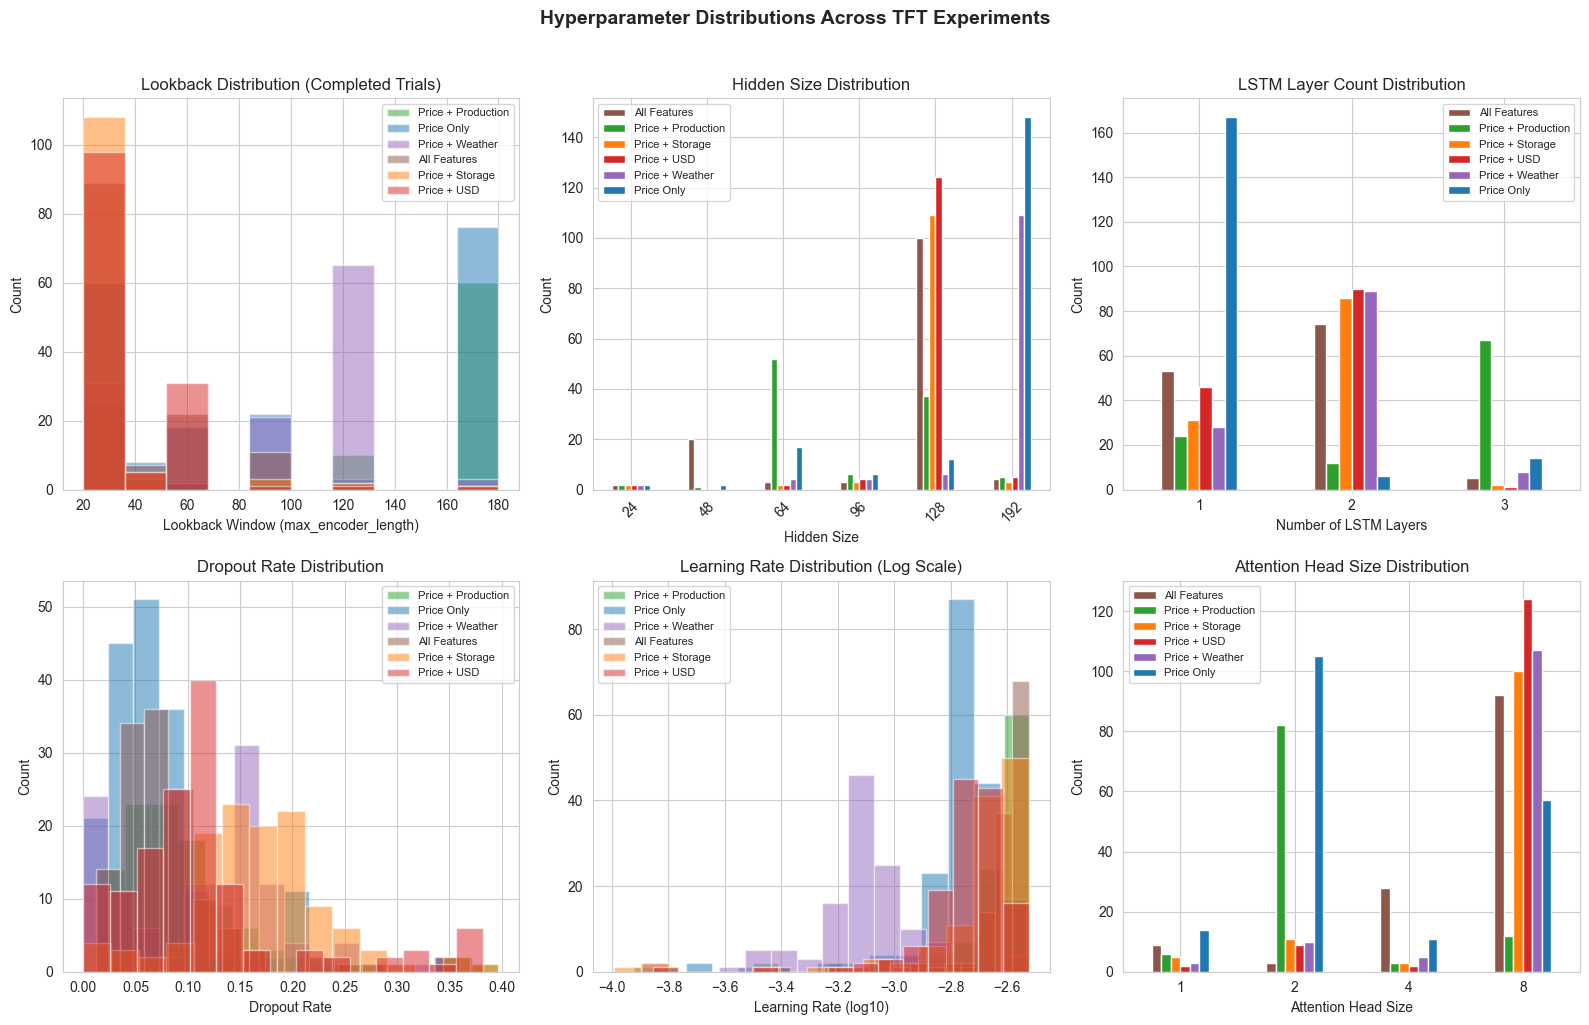

In [6]:
# === Cell 6: Hyperparameter Distribution Analysis ===

# Combine all completed trials
all_completed = []
for name, df in experiment_data.items():
    completed = df[df['state'] == 'COMPLETE'].copy()
    completed['experiment'] = name
    all_completed.append(completed)

combined_df = pd.concat(all_completed, ignore_index=True)

print(f"📊 Combined completed trials: {len(combined_df)}")

# Hyperparameter distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Lookback distribution by experiment
ax = axes[0, 0]
for name in experiment_data.keys():
    data = combined_df[combined_df['experiment'] == name]['lookback'].dropna()
    if len(data) > 0:
        ax.hist(data, bins=10, alpha=0.5, label=name, color=EXPERIMENT_COLORS.get(name, '#333'))
ax.set_xlabel('Lookback Window (max_encoder_length)')
ax.set_ylabel('Count')
ax.set_title('Lookback Distribution (Completed Trials)')
ax.legend(fontsize=8)

# 2. Hidden size distribution
ax = axes[0, 1]
hidden_sizes = combined_df.groupby(['experiment', 'hidden_size']).size().unstack(fill_value=0)
if not hidden_sizes.empty:
    hidden_sizes.T.plot(kind='bar', ax=ax, color=[EXPERIMENT_COLORS.get(exp, '#333') for exp in hidden_sizes.index])
ax.set_xlabel('Hidden Size')
ax.set_ylabel('Count')
ax.set_title('Hidden Size Distribution')
ax.legend(fontsize=8)
ax.tick_params(axis='x', rotation=45)

# 3. LSTM Layers distribution
ax = axes[0, 2]
layers = combined_df.groupby(['experiment', 'lstm_layers']).size().unstack(fill_value=0)
if not layers.empty:
    layers.T.plot(kind='bar', ax=ax, color=[EXPERIMENT_COLORS.get(exp, '#333') for exp in layers.index])
ax.set_xlabel('Number of LSTM Layers')
ax.set_ylabel('Count')
ax.set_title('LSTM Layer Count Distribution')
ax.legend(fontsize=8)
ax.tick_params(axis='x', rotation=0)

# 4. Dropout distribution
ax = axes[1, 0]
for name in experiment_data.keys():
    data = combined_df[combined_df['experiment'] == name]['dropout'].dropna()
    if len(data) > 0:
        ax.hist(data, bins=15, alpha=0.5, label=name, color=EXPERIMENT_COLORS.get(name, '#333'))
ax.set_xlabel('Dropout Rate')
ax.set_ylabel('Count')
ax.set_title('Dropout Rate Distribution')
ax.legend(fontsize=8)

# 5. Learning rate distribution (log scale)
ax = axes[1, 1]
for name in experiment_data.keys():
    data = combined_df[combined_df['experiment'] == name]['lr'].dropna()
    if len(data) > 0:
        ax.hist(np.log10(data), bins=15, alpha=0.5, label=name, color=EXPERIMENT_COLORS.get(name, '#333'))
ax.set_xlabel('Learning Rate (log10)')
ax.set_ylabel('Count')
ax.set_title('Learning Rate Distribution (Log Scale)')
ax.legend(fontsize=8)

# 6. Attention heads distribution
ax = axes[1, 2]
attn_heads = combined_df.groupby(['experiment', 'attention_head_size']).size().unstack(fill_value=0)
if not attn_heads.empty:
    attn_heads.T.plot(kind='bar', ax=ax, color=[EXPERIMENT_COLORS.get(exp, '#333') for exp in attn_heads.index])
ax.set_xlabel('Attention Head Size')
ax.set_ylabel('Count')
ax.set_title('Attention Head Size Distribution')
ax.legend(fontsize=8)
ax.tick_params(axis='x', rotation=0)

plt.suptitle('Hyperparameter Distributions Across TFT Experiments', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(SAVED_RESULTS_DIR / 'tft_hyperparam_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Hyperparameter Impact Analysis

Analyze how each hyperparameter affects validation loss across experiments.

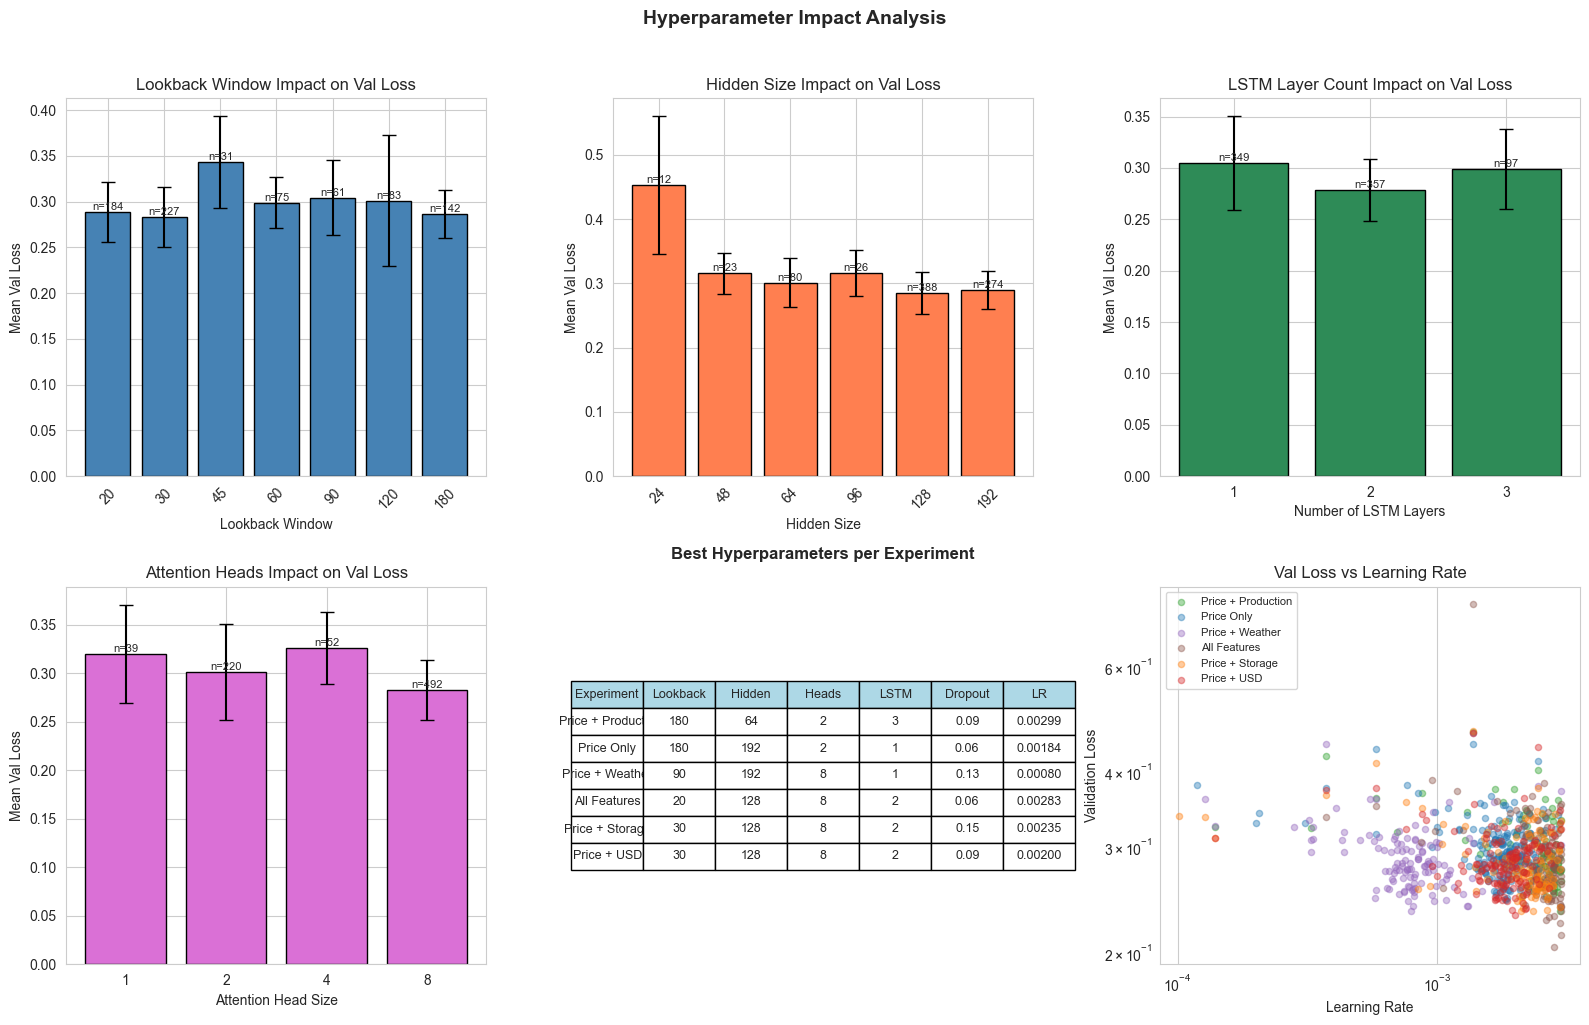

In [7]:
# === Cell 7: Hyperparameter Impact on Performance ===

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Lookback vs Val Loss
ax = axes[0, 0]
lookback_groups = combined_df.groupby('lookback')['value'].agg(['mean', 'std', 'count'])
lookback_groups.reset_index(inplace=True)
lookback_groups = lookback_groups[lookback_groups['count'] >= 5]  # min sample size
if len(lookback_groups) > 0:
    ax.bar(lookback_groups['lookback'].astype(str), lookback_groups['mean'], 
           yerr=lookback_groups['std'], capsize=5, color='steelblue', edgecolor='black')
    for i, row in lookback_groups.iterrows():
        ax.annotate(f'n={int(row["count"])}', xy=(list(lookback_groups['lookback'].astype(str)).index(str(int(row["lookback"]))), row['mean']), 
                    ha='center', va='bottom', fontsize=8)
ax.set_xlabel('Lookback Window')
ax.set_ylabel('Mean Val Loss')
ax.set_title('Lookback Window Impact on Val Loss')
ax.tick_params(axis='x', rotation=45)

# 2. Hidden size vs Val Loss
ax = axes[0, 1]
hidden_groups = combined_df.groupby('hidden_size')['value'].agg(['mean', 'std', 'count'])
hidden_groups.reset_index(inplace=True)
hidden_groups = hidden_groups[hidden_groups['count'] >= 5]
if len(hidden_groups) > 0:
    ax.bar(hidden_groups['hidden_size'].astype(str), hidden_groups['mean'],
           yerr=hidden_groups['std'], capsize=5, color='coral', edgecolor='black')
    for i, row in hidden_groups.iterrows():
        idx = list(hidden_groups['hidden_size'].astype(str)).index(str(int(row['hidden_size'])))
        ax.annotate(f'n={int(row["count"])}', xy=(idx, row['mean']), ha='center', va='bottom', fontsize=8)
ax.set_xlabel('Hidden Size')
ax.set_ylabel('Mean Val Loss')
ax.set_title('Hidden Size Impact on Val Loss')
ax.tick_params(axis='x', rotation=45)

# 3. LSTM layers vs Val Loss
ax = axes[0, 2]
layer_groups = combined_df.groupby('lstm_layers')['value'].agg(['mean', 'std', 'count'])
layer_groups.reset_index(inplace=True)
layer_groups = layer_groups[layer_groups['count'] >= 5]
if len(layer_groups) > 0:
    ax.bar(layer_groups['lstm_layers'].astype(str), layer_groups['mean'],
           yerr=layer_groups['std'], capsize=5, color='seagreen', edgecolor='black')
    for i, row in layer_groups.iterrows():
        idx = list(layer_groups['lstm_layers'].astype(str)).index(str(int(row['lstm_layers'])))
        ax.annotate(f'n={int(row["count"])}', xy=(idx, row['mean']), ha='center', va='bottom', fontsize=8)
ax.set_xlabel('Number of LSTM Layers')
ax.set_ylabel('Mean Val Loss')
ax.set_title('LSTM Layer Count Impact on Val Loss')

# 4. Attention heads vs Val Loss
ax = axes[1, 0]
attn_groups = combined_df.groupby('attention_head_size')['value'].agg(['mean', 'std', 'count'])
attn_groups.reset_index(inplace=True)
attn_groups = attn_groups[attn_groups['count'] >= 5]
if len(attn_groups) > 0:
    ax.bar(attn_groups['attention_head_size'].astype(str), attn_groups['mean'],
           yerr=attn_groups['std'], capsize=5, color='orchid', edgecolor='black')
    for i, row in attn_groups.iterrows():
        idx = list(attn_groups['attention_head_size'].astype(str)).index(str(int(row['attention_head_size'])))
        ax.annotate(f'n={int(row["count"])}', xy=(idx, row['mean']), ha='center', va='bottom', fontsize=8)
ax.set_xlabel('Attention Head Size')
ax.set_ylabel('Mean Val Loss')
ax.set_title('Attention Heads Impact on Val Loss')

# 5. Best hyperparameters per experiment table
ax = axes[1, 1]
ax.axis('off')

best_params_table = []
for name in experiment_data.keys():
    exp_data = combined_df[combined_df['experiment'] == name]
    if len(exp_data) > 0:
        best_row = exp_data.loc[exp_data['value'].idxmin()]
        best_params_table.append({
            'Experiment': name[:15] + '...' if len(name) > 15 else name,
            'Lookback': int(best_row['lookback']) if pd.notna(best_row['lookback']) else '-',
            'Hidden': int(best_row['hidden_size']) if pd.notna(best_row['hidden_size']) else '-',
            'Heads': int(best_row['attention_head_size']) if pd.notna(best_row['attention_head_size']) else '-',
            'LSTM': int(best_row['lstm_layers']) if pd.notna(best_row['lstm_layers']) else '-',
            'Dropout': f"{best_row['dropout']:.2f}" if pd.notna(best_row['dropout']) else '-',
            'LR': f"{best_row['lr']:.5f}" if pd.notna(best_row['lr']) else '-'
        })

best_params_tbl_df = pd.DataFrame(best_params_table)
table = ax.table(cellText=best_params_tbl_df.values, colLabels=best_params_tbl_df.columns,
                 cellLoc='center', loc='center', colColours=['lightblue']*len(best_params_tbl_df.columns))
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
ax.set_title('Best Hyperparameters per Experiment', fontsize=12, fontweight='bold', pad=20)

# 6. Learning rate scatter
ax = axes[1, 2]
for name in experiment_data.keys():
    data = combined_df[combined_df['experiment'] == name]
    ax.scatter(data['lr'], data['value'], alpha=0.4, label=name, 
               color=EXPERIMENT_COLORS.get(name, '#333'), s=20)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.set_title('Val Loss vs Learning Rate')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=8)

plt.suptitle('Hyperparameter Impact Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(SAVED_RESULTS_DIR / 'tft_hyperparam_impact.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Cross-Experiment Optimal Parameter Analysis

Identify which parameter configurations consistently perform well across all experiments.

OPTIMAL HYPERPARAMETER RANGES ACROSS ALL EXPERIMENTS

📊 Analyzing 60 top models (top-10 per experiment)
------------------------------------------------------------

🔍 LOOKBACK WINDOW (max_encoder_length):
     30 days:  21 models ( 35.0%)
    180 days:  15 models ( 25.0%)
     20 days:  13 models ( 21.7%)
     90 days:   4 models (  6.7%)
    120 days:   4 models (  6.7%)
     60 days:   3 models (  5.0%)

🔍 HIDDEN SIZE:
    128     :  30 models ( 50.0%)
    192     :  21 models ( 35.0%)
     64     :   8 models ( 13.3%)
     96     :   1 models (  1.7%)

🔍 LSTM LAYERS:
      2 layer(s):  35 models ( 58.3%)
      1 layer(s):  15 models ( 25.0%)
      3 layer(s):  10 models ( 16.7%)

🔍 ATTENTION HEAD SIZE:
      8 heads :  42 models ( 70.0%)
      2 heads :  17 models ( 28.3%)
      1 heads :   1 models (  1.7%)

🔍 LEARNING RATE STATISTICS (Top Models):
   Min:    0.000575
   Max:    0.002999
   Mean:   0.002101
   Median: 0.002120
   Std:    0.000686


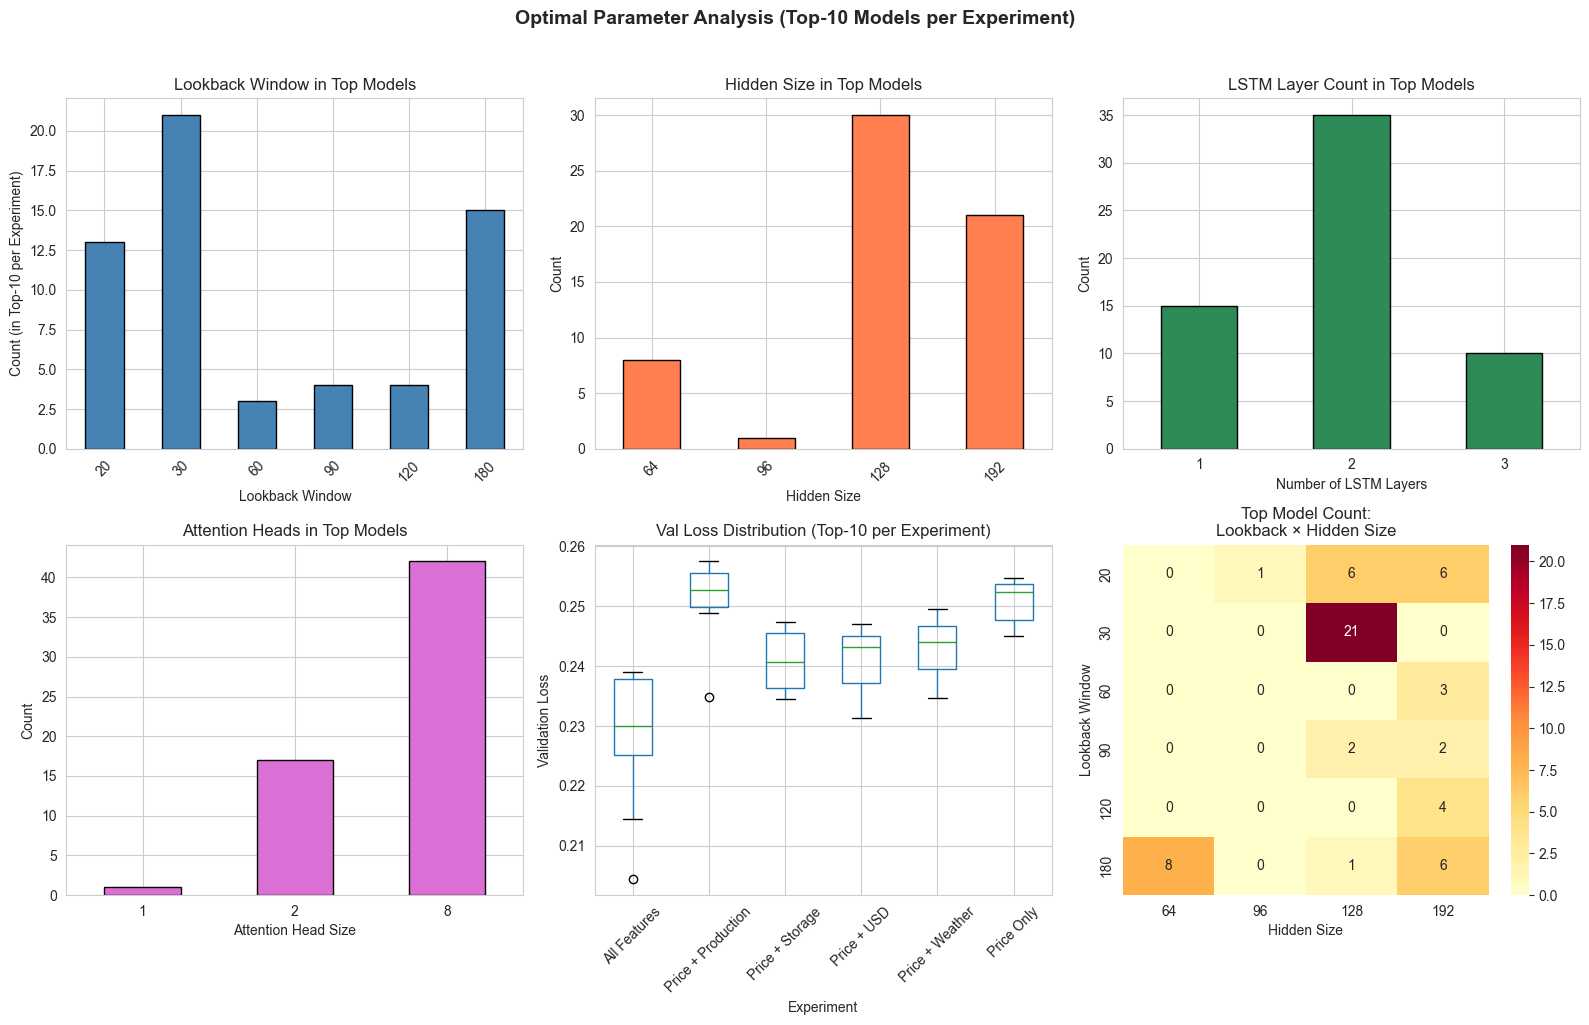

In [8]:
# === Cell 8: Cross-Experiment Optimal Parameter Analysis ===

print("=" * 80)
print("OPTIMAL HYPERPARAMETER RANGES ACROSS ALL EXPERIMENTS")
print("=" * 80)

# Get top 10 models from each experiment
top_models_per_exp = []
for name, df in experiment_data.items():
    completed = df[df['state'] == 'COMPLETE'].copy()
    completed['experiment'] = name
    if len(completed) > 0:
        top_10 = completed.nsmallest(min(10, len(completed)), 'value')
        top_models_per_exp.append(top_10)

top_combined = pd.concat(top_models_per_exp, ignore_index=True)

print(f"\n📊 Analyzing {len(top_combined)} top models (top-10 per experiment)")
print("-" * 60)

# Lookback analysis
print("\n🔍 LOOKBACK WINDOW (max_encoder_length):")
lookback_counts = top_combined['lookback'].value_counts()
for lb, count in lookback_counts.items():
    pct = count / len(top_combined) * 100
    print(f"   {int(lb):4d} days: {count:3d} models ({pct:5.1f}%)")

# Hidden size analysis
print("\n🔍 HIDDEN SIZE:")
hidden_counts = top_combined['hidden_size'].value_counts()
for hs, count in hidden_counts.items():
    pct = count / len(top_combined) * 100
    print(f"   {int(hs):4d}     : {count:3d} models ({pct:5.1f}%)")

# LSTM Layers
print("\n🔍 LSTM LAYERS:")
layer_counts = top_combined['lstm_layers'].value_counts()
for layers, count in layer_counts.items():
    pct = count / len(top_combined) * 100
    print(f"   {int(layers):4d} layer(s): {count:3d} models ({pct:5.1f}%)")

# Attention heads
print("\n🔍 ATTENTION HEAD SIZE:")
attn_counts = top_combined['attention_head_size'].value_counts()
for heads, count in attn_counts.items():
    pct = count / len(top_combined) * 100
    print(f"   {int(heads):4d} heads : {count:3d} models ({pct:5.1f}%)")

# Learning rate
print("\n🔍 LEARNING RATE STATISTICS (Top Models):")
lr_stats = top_combined['lr'].describe()
print(f"   Min:    {lr_stats['min']:.6f}")
print(f"   Max:    {lr_stats['max']:.6f}")
print(f"   Mean:   {lr_stats['mean']:.6f}")
print(f"   Median: {lr_stats['50%']:.6f}")
print(f"   Std:    {lr_stats['std']:.6f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Lookback in top models
ax = axes[0, 0]
lookback_counts.sort_index().plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Lookback Window')
ax.set_ylabel('Count (in Top-10 per Experiment)')
ax.set_title('Lookback Window in Top Models')
ax.tick_params(axis='x', rotation=45)

# 2. Hidden size in top models
ax = axes[0, 1]
hidden_counts.sort_index().plot(kind='bar', ax=ax, color='coral', edgecolor='black')
ax.set_xlabel('Hidden Size')
ax.set_ylabel('Count')
ax.set_title('Hidden Size in Top Models')
ax.tick_params(axis='x', rotation=45)

# 3. LSTM layers in top models
ax = axes[0, 2]
layer_counts.sort_index().plot(kind='bar', ax=ax, color='seagreen', edgecolor='black')
ax.set_xlabel('Number of LSTM Layers')
ax.set_ylabel('Count')
ax.set_title('LSTM Layer Count in Top Models')
ax.tick_params(axis='x', rotation=0)

# 4. Attention heads in top models
ax = axes[1, 0]
attn_counts.sort_index().plot(kind='bar', ax=ax, color='orchid', edgecolor='black')
ax.set_xlabel('Attention Head Size')
ax.set_ylabel('Count')
ax.set_title('Attention Heads in Top Models')
ax.tick_params(axis='x', rotation=0)

# 5. Val Loss distribution by experiment (top models only)
ax = axes[1, 1]
top_combined.boxplot(column='value', by='experiment', ax=ax, grid=True)
ax.set_xlabel('Experiment')
ax.set_ylabel('Validation Loss')
ax.set_title('Val Loss Distribution (Top-10 per Experiment)')
plt.suptitle('')  # Remove automatic title
ax.tick_params(axis='x', rotation=45)

# 6. Heatmap of best parameter combinations (Lookback × Hidden Size)
ax = axes[1, 2]
cross_tab = pd.crosstab(top_combined['lookback'], top_combined['hidden_size'])
if cross_tab.size > 0:
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
ax.set_xlabel('Hidden Size')
ax.set_ylabel('Lookback Window')
ax.set_title('Top Model Count:\nLookback × Hidden Size')

plt.suptitle('Optimal Parameter Analysis (Top-10 Models per Experiment)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(SAVED_RESULTS_DIR / 'tft_optimal_params.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Optimization Convergence Analysis

Analyze how the optimization progressed over trials.

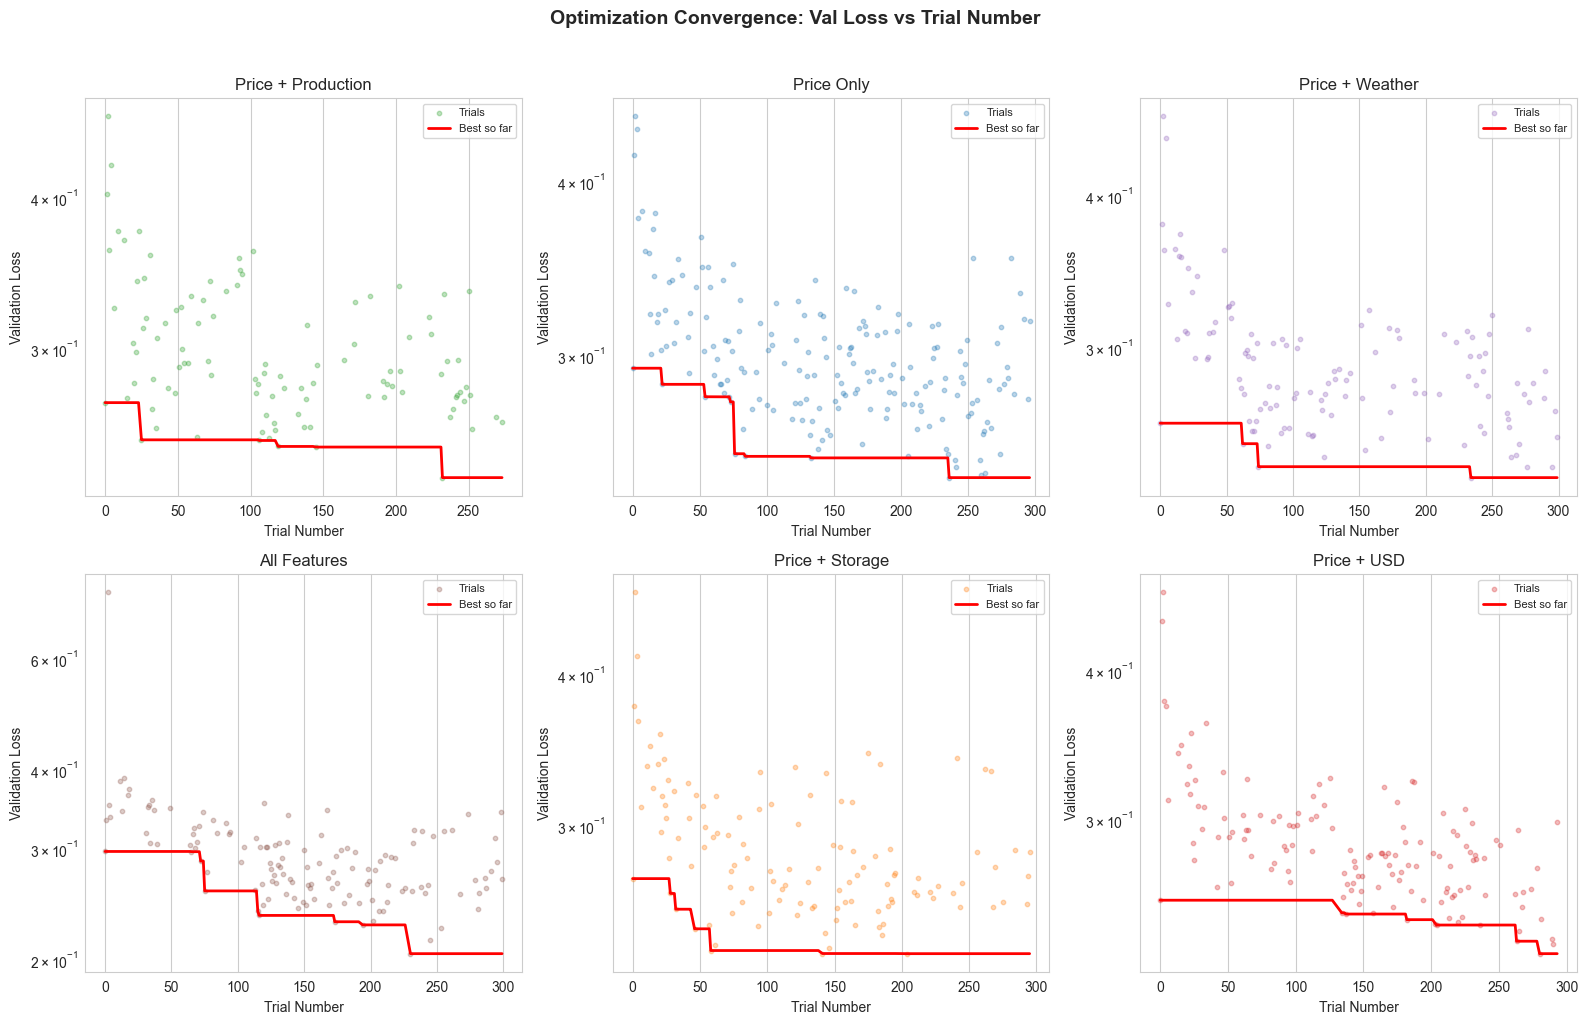


OPTIMIZATION CONVERGENCE SUMMARY


,Experiment,Total Trials,Completed Trials,Final Best Val Loss,Trial Achieving 95% of Best,Efficiency (%)
0,Price + Production,300,103,0.234777,232,77.3
1,Price Only,300,187,0.245121,76,25.3
2,Price + Weather,300,125,0.234662,74,24.7
3,All Features,300,132,0.204424,230,76.7
4,Price + Storage,300,119,0.234566,46,15.3
5,Price + USD,300,137,0.231281,263,87.7


In [9]:
# === Cell 9: Optimization Convergence Analysis ===

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, df) in enumerate(experiment_data.items()):
    if idx >= len(axes):
        break
    ax = axes[idx]
    
    completed = df[df['state'] == 'COMPLETE'].copy()
    completed = completed.sort_values('trial_number')
    
    if len(completed) == 0:
        ax.text(0.5, 0.5, 'No completed trials', ha='center', va='center', transform=ax.transAxes)
        continue
    
    # Calculate cumulative best
    completed['cumulative_best'] = completed['value'].cummin()
    
    # Plot individual trials
    ax.scatter(completed['trial_number'], completed['value'], 
               alpha=0.3, s=10, c=EXPERIMENT_COLORS.get(name, '#333'), label='Trials')
    
    # Plot cumulative best
    ax.plot(completed['trial_number'], completed['cumulative_best'], 
            color='red', linewidth=2, label='Best so far')
    
    ax.set_xlabel('Trial Number')
    ax.set_ylabel('Validation Loss')
    ax.set_title(f'{name}')
    ax.legend(fontsize=8)
    ax.set_yscale('log')

# Hide unused axes
for idx in range(len(experiment_data), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Optimization Convergence: Val Loss vs Trial Number', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(SAVED_RESULTS_DIR / 'tft_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary of convergence
print("\n" + "=" * 80)
print("OPTIMIZATION CONVERGENCE SUMMARY")
print("=" * 80)

convergence_data = []
for name, df in experiment_data.items():
    completed = df[df['state'] == 'COMPLETE'].copy()
    completed = completed.sort_values('trial_number')
    
    if len(completed) == 0:
        continue
    
    # Find trial where we got within 5% of best
    final_best = completed['value'].min()
    threshold = final_best * 1.05
    
    completed['cumulative_best'] = completed['value'].cummin()
    close_trials = completed[completed['cumulative_best'] <= threshold]
    
    if len(close_trials) > 0:
        first_good_trial = int(close_trials['trial_number'].iloc[0])
    else:
        first_good_trial = None
    
    convergence_data.append({
        'Experiment': name,
        'Total Trials': len(df),
        'Completed Trials': len(completed),
        'Final Best Val Loss': f"{final_best:.6f}",
        'Trial Achieving 95% of Best': first_good_trial,
        'Efficiency (%)': round(first_good_trial / len(df) * 100, 1) if first_good_trial else None
    })

convergence_df = pd.DataFrame(convergence_data)
display(convergence_df)

## 9. Re-Train Best Models for Missing Predictions

For experiments without saved prediction data (`final_test_metrics.json`), we retrain the best model using the hyperparameters from the trial with the lowest validation loss.

**Process:**
1. Load the best hyperparameters from trial summary
2. Rebuild the TFT model with those parameters
3. Train with early stopping on validation loss
4. Generate predictions on the test set
5. Calculate metrics (MAE, RMSE, MAPE, Directional Accuracy)

In [ ]:
# === Cell 10: Re-Train Best Models for Missing Predictions ===

# Check if we need to re-train any models
experiments_needing_retrain = [name for name in experiment_data.keys() if name not in final_metrics_data]

if len(experiments_needing_retrain) == 0:
    print("✅ All experiments have saved predictions - no retraining needed!")
else:
    print(f"⚠️ {len(experiments_needing_retrain)} experiments need retraining:")
    for name in experiments_needing_retrain:
        print(f"   • {name}")
 
# Check if pytorch-forecasting is available
try:
    import torch
    import lightning.pytorch as pl
    from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
    from pytorch_forecasting.data import GroupNormalizer
    from pytorch_forecasting.metrics import QuantileLoss
    from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    
    PYTORCH_AVAILABLE = True
    print("✅ PyTorch and pytorch-forecasting available!")
    
except ImportError as e:
    PYTORCH_AVAILABLE = False
    print(f"⚠️ PyTorch/pytorch-forecasting not available: {e}")
    print("   Install with: pip install torch lightning pytorch-forecasting")

# Feature configurations for each experiment
FEATURE_CONFIGS = {
    "Price Only": {
        "num_cols": [],
        "csv_path": "../numeric_data/henryhub_master.csv"
    },
    "Price + Storage": {
        "num_cols": ["storage_bcf"],
        "csv_path": "../numeric_data/henryhub_master.csv"
    },
    "Price + Production": {
        "num_cols": ["production_bcf"],
        "csv_path": "../numeric_data/henryhub_master.csv"
    },
    "Price + USD": {
        "num_cols": ["usd_index"],
        "csv_path": "../numeric_data/henryhub_master.csv"
    },
    "Price + Weather": {
        "num_cols": ["temp_c", "temp_max_c", "temp_min_c"],
        "csv_path": "../numeric_data/henryhub_master.csv"
    },
    "All Features": {
        "num_cols": ["storage_bcf", "production_bcf", "usd_index", "temp_c", "temp_max_c", "temp_min_c"],
        "csv_path": "../numeric_data/henryhub_master.csv"
    }
}

# Filename mapping for experiments (matching LSTM convention)
EXPERIMENT_FILENAME_MAP = {
    "Price Only": "price_only",
    "Price + Storage": "price_storage",
    "Price + Production": "price_prod",
    "Price + USD": "price_usd",
    "Price + Weather": "price_weather",
    "All Features": "price_stor_prod_usd_weather"
}

if PYTORCH_AVAILABLE:
    
    def load_tft_data(csv_path: str, num_cols: list):
        """Load and prepare data for TFT."""
        df = pd.read_csv(csv_path, parse_dates=["date"])
        df = df.sort_values(["id", "date"]).reset_index(drop=True)
        
        df["id"] = df["id"].astype(str).astype("category")
        df["price"] = pd.to_numeric(df["price"], errors="coerce").astype("float32")
        
        for c in num_cols:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")
        
        df["time_idx"] = df.groupby("id").cumcount().astype(np.int64)
        df["dow"] = df["date"].dt.dayofweek.astype(str).astype("category")
        df["month"] = df["date"].dt.month.astype(str).astype("category")
        
        return df
    
    def build_tft_datasets_with_cutoffs(df, lookback, horizon=1, test_frac=0.15, val_frac=0.15):
        """Build train/val/test datasets with explicit cutoffs."""
        df = df.sort_values("date").reset_index(drop=True).copy()
        n = len(df)
        
        n_test = int(n * test_frac)
        n_trainval = n - n_test
        n_val = int(n_trainval * val_frac)
        n_train = n_trainval - n_val
        
        train_cutoff = int(df.iloc[n_train - 1]["time_idx"])
        val_cutoff = int(df.iloc[n_train + n_val - 1]["time_idx"])
        
        # Identify numeric columns for time_varying_unknown_reals
        time_varying_unknown_reals = ["price"]
        for c in df.columns:
            if c not in ["date", "id", "time_idx", "dow", "month", "price"] and pd.api.types.is_numeric_dtype(df[c]):
                time_varying_unknown_reals.append(c)
        
        common_args = dict(
            time_idx="time_idx",
            target="price",
            group_ids=["id"],
            max_encoder_length=lookback,
            min_encoder_length=lookback,
            max_prediction_length=horizon,
            time_varying_known_reals=["time_idx"],
            time_varying_known_categoricals=["dow", "month"],
            time_varying_unknown_reals=time_varying_unknown_reals,
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
            target_normalizer=GroupNormalizer(groups=["id"]),
        )
        
        train_ds = TimeSeriesDataSet(df[df["time_idx"] <= train_cutoff].copy(), **common_args, min_prediction_idx=lookback)
        val_ds = TimeSeriesDataSet(df[df["time_idx"] <= val_cutoff].copy(), **common_args, min_prediction_idx=train_cutoff + 1)
        test_ds = TimeSeriesDataSet(df.copy(), **common_args, min_prediction_idx=val_cutoff + 1)
        
        return train_ds, val_ds, test_ds, train_cutoff, val_cutoff
    
    def retrain_and_predict(experiment_name: str, params: dict, top_k: int = 10):
        """Retrain TFT model with given params and generate predictions."""
        if experiment_name not in FEATURE_CONFIGS:
            print(f"⚠️ No config for {experiment_name}")
            return None
        
        config = FEATURE_CONFIGS[experiment_name]
        
        # Load data
        print(f"   Loading data for {experiment_name}...")
        df = load_tft_data(config["csv_path"], config["num_cols"])
        
        # Get hyperparameters from params
        lookback = params.get("max_encoder_length", 60)
        batch_size = params.get("batch_size", 64)
        hidden_size = params.get("hidden_size", 32)
        attention_head_size = params.get("attention_head_size", 4)
        hidden_continuous_size = params.get("hidden_continuous_size", 16)
        dropout = params.get("dropout", 0.1)
        lstm_layers = params.get("lstm_layers", 1)
        lr = params.get("learning_rate", 1e-3)
        gradient_clip_val = params.get("gradient_clip_val", 0.1)
        
        # Ensure attention heads divide hidden size
        while hidden_size % attention_head_size != 0:
            attention_head_size -= 1
            if attention_head_size < 1:
                attention_head_size = 1
                break
        
        # Ensure hidden_continuous_size <= hidden_size
        hidden_continuous_size = min(hidden_continuous_size, hidden_size)
        
        print(f"   Building datasets (lookback={lookback})...")
        train_ds, val_ds, test_ds, _, _ = build_tft_datasets_with_cutoffs(df, lookback=lookback)
        
        train_loader = train_ds.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
        val_loader = val_ds.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
        test_loader = test_ds.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
        
        print(f"   Training TFT model...")
        quantiles = (0.05, 0.25, 0.5, 0.75, 0.95)
        
        model = TemporalFusionTransformer.from_dataset(
            train_ds,
            learning_rate=lr,
            hidden_size=hidden_size,
            attention_head_size=attention_head_size,
            hidden_continuous_size=hidden_continuous_size,
            dropout=dropout,
            lstm_layers=lstm_layers,
            loss=QuantileLoss(list(quantiles)),
        )
        
        callbacks = [
            EarlyStopping(monitor="val_loss", patience=8, mode="min", verbose=False),
        ]
        
        accelerator = "gpu" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        devices = 1 if accelerator != "cpu" else None
        
        trainer = pl.Trainer(
            max_epochs=60,
            accelerator=accelerator,
            devices=devices,
            callbacks=callbacks,
            enable_progress_bar=True,
            enable_model_summary=False,
            logger=False,
            gradient_clip_val=gradient_clip_val,
        )
        
        trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
        
        # Generate predictions
        print(f"   Generating predictions...")
        predictions = model.predict(test_loader, mode="prediction", return_y=True)
        
        # Extract p50 predictions and actuals
        y_pred_all = predictions.output
        y_true_all = predictions.y[0] if isinstance(predictions.y, tuple) else predictions.y
        
        # Get P50 (index 2 for quantiles [0.05, 0.25, 0.5, 0.75, 0.95])
        if len(y_pred_all.shape) == 3:
            y_pred_p50 = y_pred_all[:, :, 2].flatten().cpu().numpy()
        else:
            y_pred_p50 = y_pred_all.flatten().cpu().numpy()
        
        y_true = y_true_all.flatten().cpu().numpy()
        
        # Align lengths
        min_len = min(len(y_true), len(y_pred_p50))
        y_true = y_true[:min_len]
        y_pred_p50 = y_pred_p50[:min_len]
        
        # Calculate metrics
        mae = float(np.mean(np.abs(y_true - y_pred_p50)))
        rmse = float(np.sqrt(np.mean((y_true - y_pred_p50) ** 2)))
        mape = float(np.mean(np.abs((y_true - y_pred_p50) / np.clip(np.abs(y_true), 1e-6, None))) * 100)
        
        # Directional accuracy
        true_dir = np.sign(np.diff(y_true))
        pred_dir = np.sign(np.diff(y_pred_p50))
        da = float((true_dir == pred_dir).mean() * 100)
        
        print(f"   ✅ MAE={mae:.4f}, RMSE={rmse:.4f}, MAPE={mape:.2f}%, DA={da:.1f}%")
        
        return {
            'y_true': y_true.tolist(),
            'y_pred_p50': y_pred_p50.tolist(),
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'Directional_Accuracy': da
        }
    
    print("\n✅ Retraining functions defined")

⚠️ 5 experiments need retraining:
   • Price + Production
   • Price + Weather
   • All Features
   • Price + Storage
   • Price + USD
✅ PyTorch and pytorch-forecasting available!

✅ Retraining functions defined


In [11]:
# === Cell 10b: Execute Retraining for Missing Experiments ===

if PYTORCH_AVAILABLE and len(experiments_needing_retrain) > 0:
    print("=" * 80)
    print("RETRAINING BEST MODELS FOR MISSING EXPERIMENTS")
    print("=" * 80)
    
    for exp_name in experiments_needing_retrain:
        print(f"\n🔄 Processing: {exp_name}")
        print("-" * 60)
        
        # Get best params from trial summary (top model)
        if exp_name in experiment_data:
            df = experiment_data[exp_name]
            completed = df[df['state'] == 'COMPLETE'].copy()
            
            if len(completed) > 0:
                # Get best trial's params
                best_idx = completed['value'].idxmin()
                best_trial = completed.loc[best_idx]
                
                # Build params dict from parsed columns
                params = {
                    'max_encoder_length': int(best_trial.get('lookback', 60)) if pd.notna(best_trial.get('lookback')) else 60,
                    'batch_size': int(best_trial.get('batch_size', 64)) if pd.notna(best_trial.get('batch_size')) else 64,
                    'hidden_size': int(best_trial.get('hidden_size', 32)) if pd.notna(best_trial.get('hidden_size')) else 32,
                    'attention_head_size': int(best_trial.get('attention_head_size', 4)) if pd.notna(best_trial.get('attention_head_size')) else 4,
                    'hidden_continuous_size': int(best_trial.get('hidden_continuous_size', 16)) if pd.notna(best_trial.get('hidden_continuous_size')) else 16,
                    'dropout': float(best_trial.get('dropout', 0.1)) if pd.notna(best_trial.get('dropout')) else 0.1,
                    'lstm_layers': int(best_trial.get('lstm_layers', 1)) if pd.notna(best_trial.get('lstm_layers')) else 1,
                    'learning_rate': float(best_trial.get('lr', 1e-3)) if pd.notna(best_trial.get('lr')) else 1e-3,
                    'gradient_clip_val': float(best_trial.get('gradient_clip_val', 0.1)) if pd.notna(best_trial.get('gradient_clip_val')) else 0.1,
                }
                
                print(f"   Using params from Trial #{int(best_trial['trial_number'])} (Val Loss: {best_trial['value']:.6f})")
                
                try:
                    result = retrain_and_predict(exp_name, params)
                    
                    if result is not None:
                        # Store in final_metrics_data
                        final_metrics_data[exp_name] = {
                            'y_true': np.array(result['y_true']),
                            'y_pred_p50': np.array(result['y_pred_p50']),
                            'MAE': result['MAE'],
                            'RMSE': result['RMSE'],
                            'MAPE': result['MAPE'],
                            'Directional_Accuracy': result['Directional_Accuracy']
                        }
                        print(f"   ✅ Successfully generated predictions for {exp_name}")
                except Exception as e:
                    print(f"   ❌ Error retraining {exp_name}: {e}")
            else:
                print(f"   ⚠️ No completed trials found for {exp_name}")
        else:
            print(f"   ⚠️ No experiment data found for {exp_name}")
    
    print("\n" + "=" * 80)
    print(f"✅ Retraining complete! Now have predictions for {len(final_metrics_data)} experiments")
else:
    if not PYTORCH_AVAILABLE:
        print("⚠️ PyTorch not available - cannot retrain models")
    else:
        print("✅ All experiments already have predictions!")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


RETRAINING BEST MODELS FOR MISSING EXPERIMENTS

🔄 Processing: Price + Production
------------------------------------------------------------
   Using params from Trial #232 (Val Loss: 0.234777)
   Loading data for Price + Production...
   Building datasets (lookback=180)...
   Training TFT model...
Epoch 21: 100%|██████████| 86/86 [00:20<00:00,  4.28it/s, train_loss_step=0.0439, val_loss=0.508, train_loss_epoch=0.0724]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


   Generating predictions...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


   ✅ MAE=0.1883, RMSE=0.6319, MAPE=6.13%, DA=43.5%
   ✅ Successfully generated predictions for Price + Production

🔄 Processing: Price + Weather
------------------------------------------------------------
   Using params from Trial #234 (Val Loss: 0.234662)
   Loading data for Price + Weather...
   Building datasets (lookback=90)...
   Training TFT model...
Epoch 17: 100%|██████████| 89/89 [00:12<00:00,  7.34it/s, train_loss_step=0.0456, val_loss=0.370, train_loss_epoch=0.0688]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


   Generating predictions...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


   ✅ MAE=0.1850, RMSE=0.6124, MAPE=5.96%, DA=45.0%
   ✅ Successfully generated predictions for Price + Weather

🔄 Processing: All Features
------------------------------------------------------------
   Using params from Trial #230 (Val Loss: 0.204424)
   Loading data for All Features...
   Building datasets (lookback=20)...
   Training TFT model...
Epoch 15: 100%|██████████| 91/91 [00:09<00:00,  9.24it/s, train_loss_step=0.0848, val_loss=0.540, train_loss_epoch=0.0773]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


   Generating predictions...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


   ✅ MAE=0.2108, RMSE=0.6420, MAPE=7.63%, DA=44.0%
   ✅ Successfully generated predictions for All Features

🔄 Processing: Price + Storage
------------------------------------------------------------
   Using params from Trial #204 (Val Loss: 0.234566)
   Loading data for Price + Storage...
   Building datasets (lookback=30)...
   Training TFT model...
Epoch 15: 100%|██████████| 91/91 [00:10<00:00,  8.98it/s, train_loss_step=0.0562, val_loss=0.375, train_loss_epoch=0.075] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


   Generating predictions...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


   ✅ MAE=0.2155, RMSE=0.6272, MAPE=7.51%, DA=43.7%
   ✅ Successfully generated predictions for Price + Storage

🔄 Processing: Price + USD
------------------------------------------------------------
   Using params from Trial #280 (Val Loss: 0.231281)
   Loading data for Price + USD...
   Building datasets (lookback=30)...
   Training TFT model...
Epoch 11: 100%|██████████| 91/91 [00:10<00:00,  8.60it/s, train_loss_step=0.0615, val_loss=0.408, train_loss_epoch=0.0775]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores



   Generating predictions...
   ✅ MAE=0.2043, RMSE=0.6221, MAPE=6.98%, DA=44.8%
   ✅ Successfully generated predictions for Price + USD

✅ Retraining complete! Now have predictions for 6 experiments


## 10. Prediction vs Actual Visualizations

Plot predictions for each experiment in LSTM-consistent format:
- Individual full-page plots per experiment with metrics box
- Experiment name in plot titles and filenames
- Combined overview plot for quick comparison
- Filename format: `tft_<experiment>_pred_vs_actual.png`

TFT PREDICTION VS ACTUAL PLOTS (Individual per Experiment)

📈 Price + Production:
   📊 Saved: tft_price_prod_pred_vs_actual.png


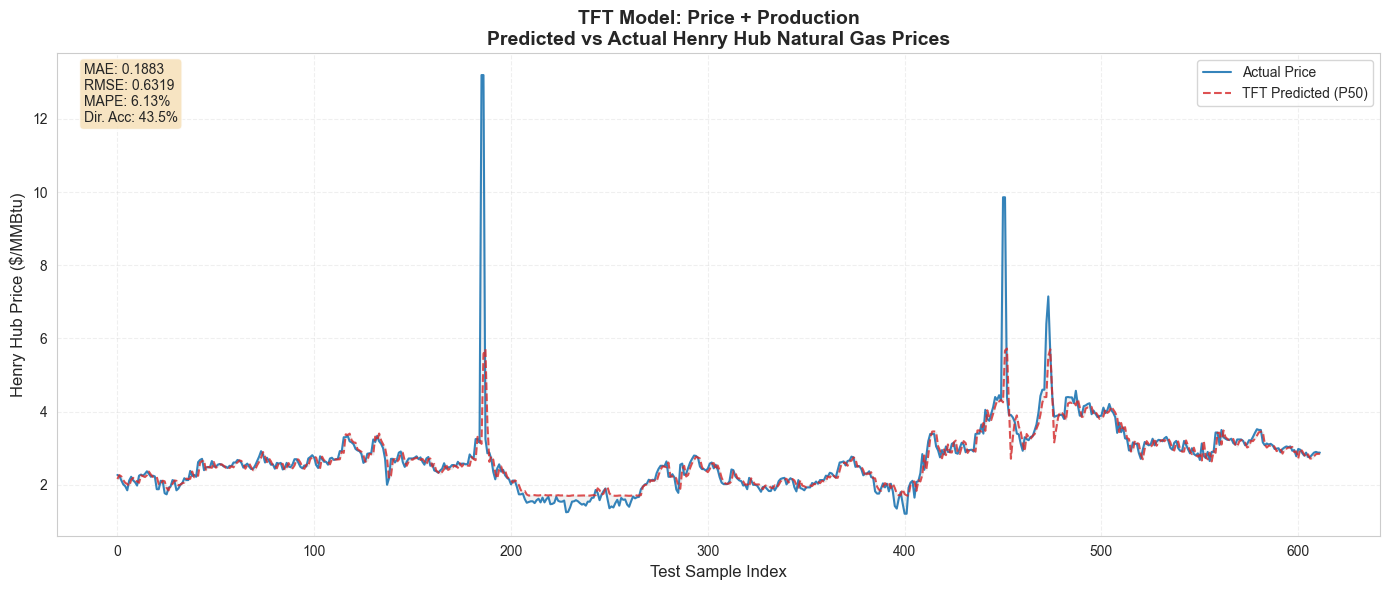


📈 Price Only:
   📊 Saved: tft_price_only_pred_vs_actual.png


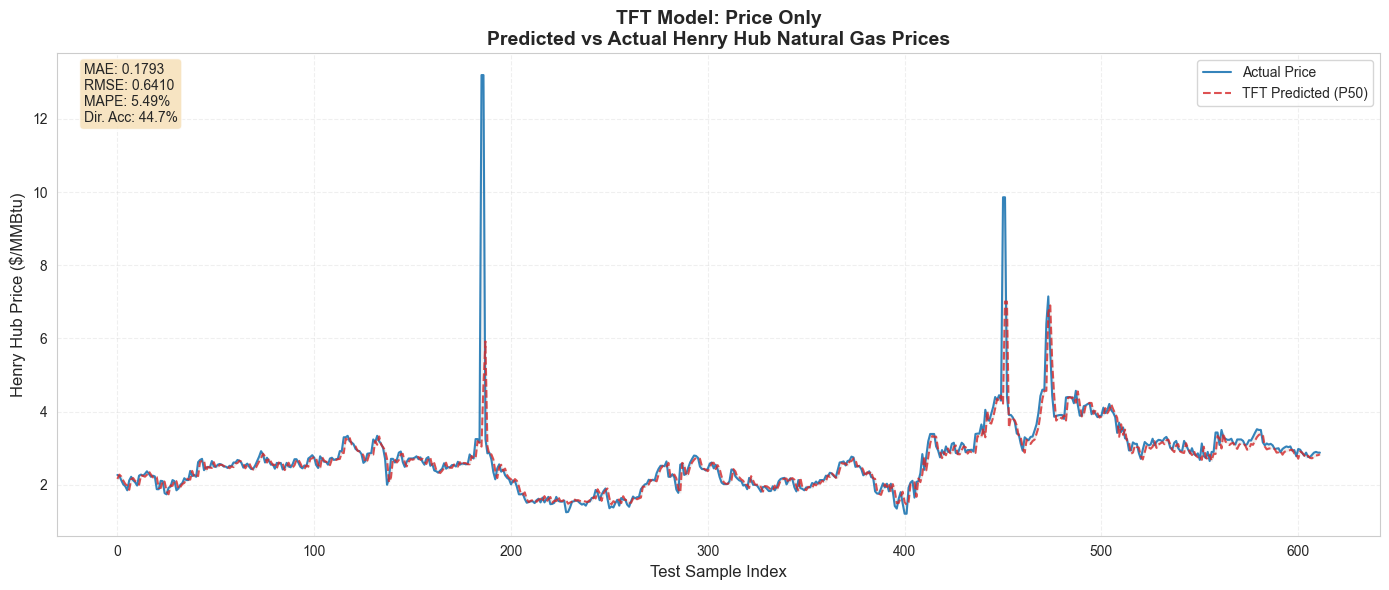


📈 Price + Weather:
   📊 Saved: tft_price_weather_pred_vs_actual.png


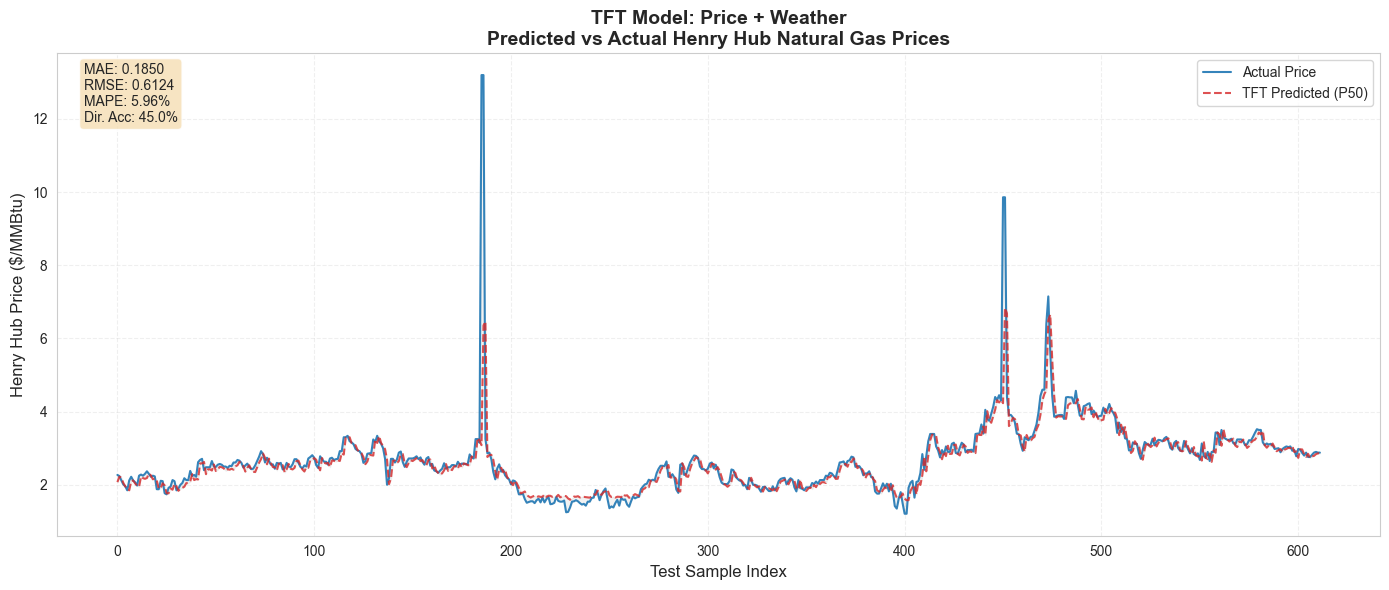


📈 All Features:
   📊 Saved: tft_price_stor_prod_usd_weather_pred_vs_actual.png


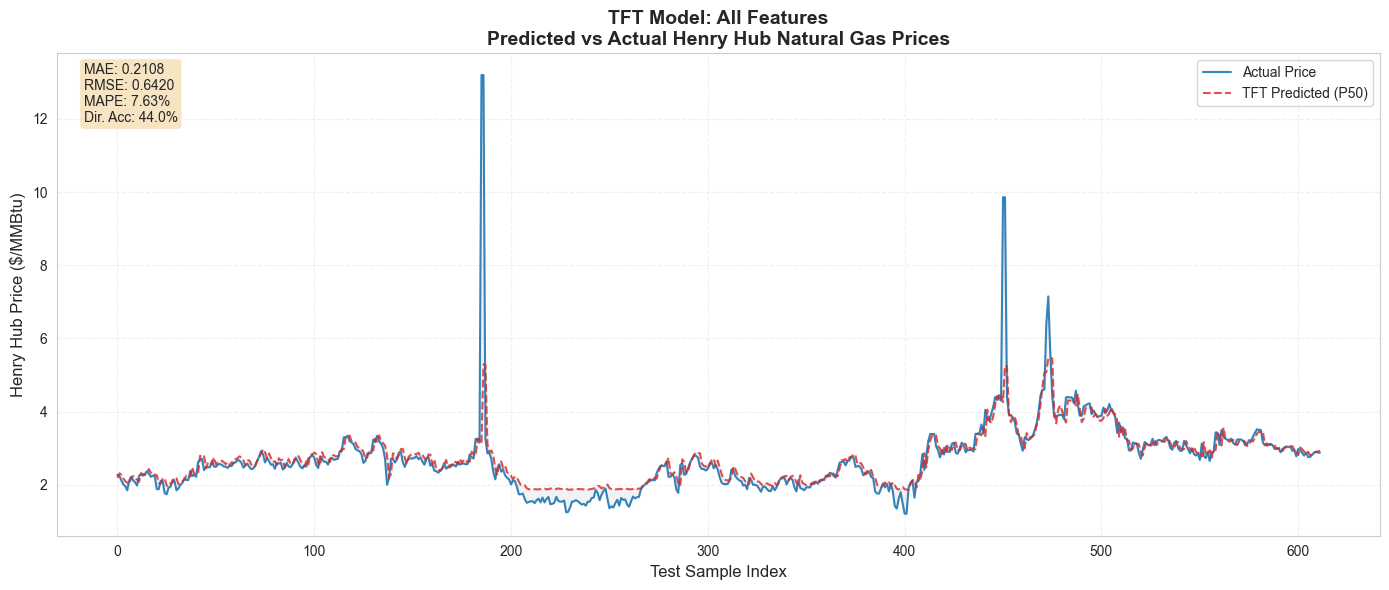


📈 Price + Storage:
   📊 Saved: tft_price_storage_pred_vs_actual.png


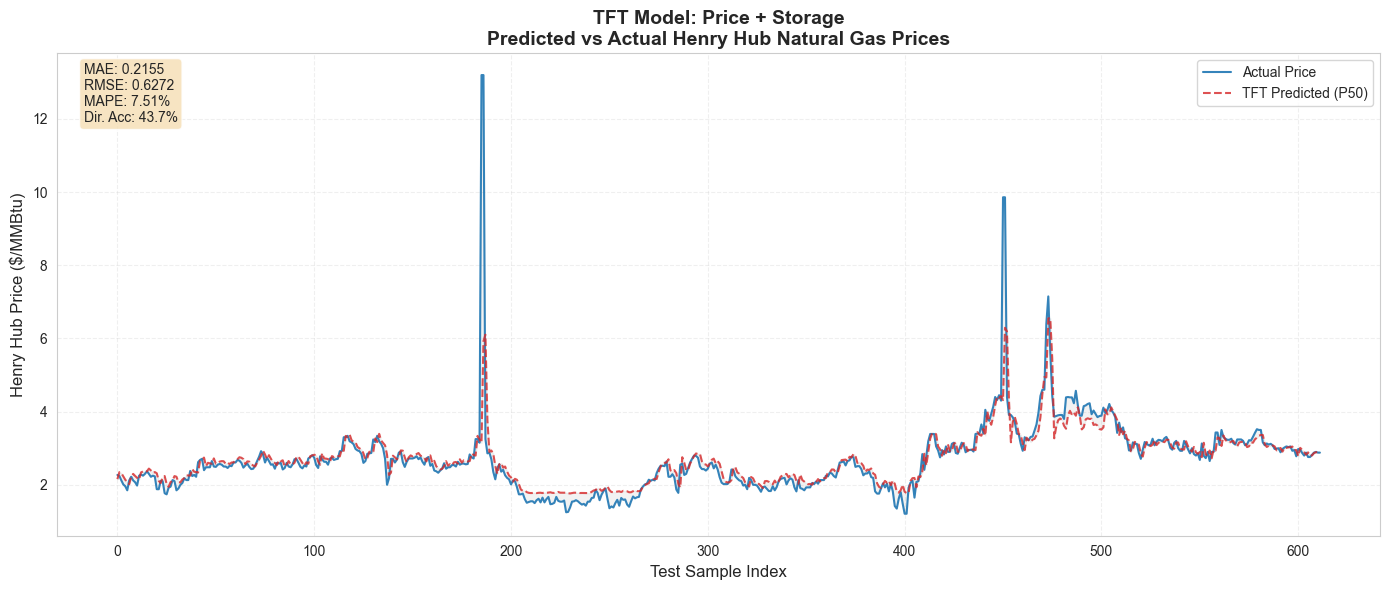


📈 Price + USD:
   📊 Saved: tft_price_usd_pred_vs_actual.png


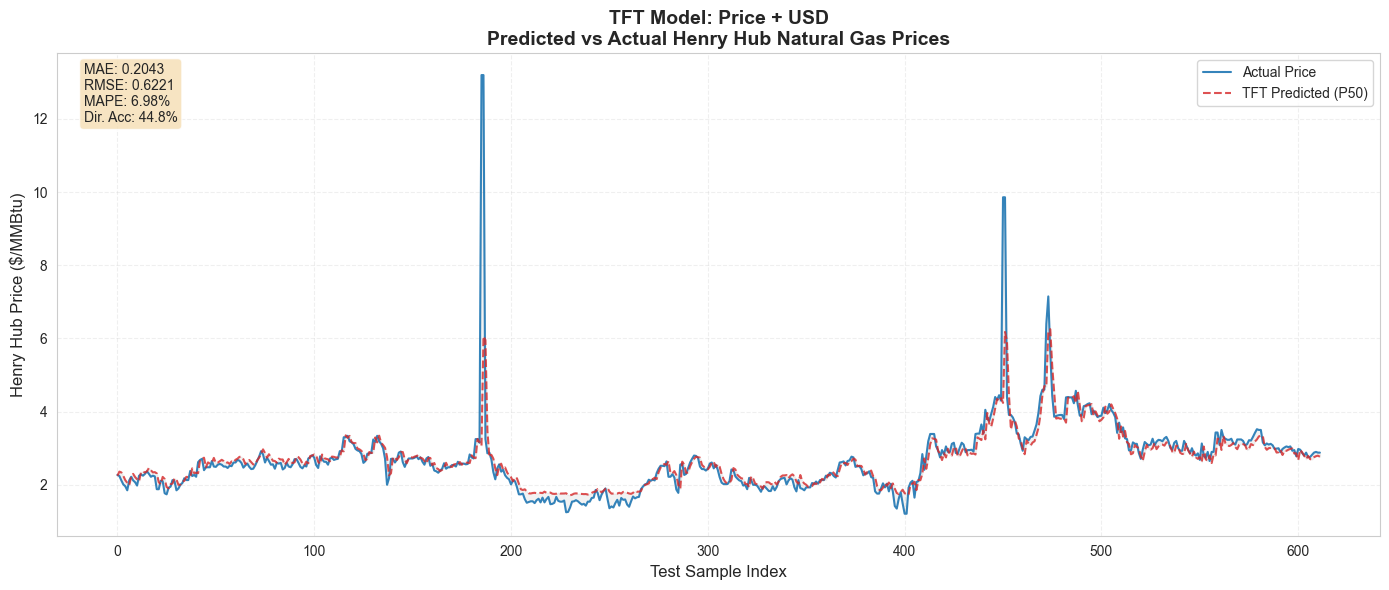


------------------------------------------------------------
Creating combined overview plot...


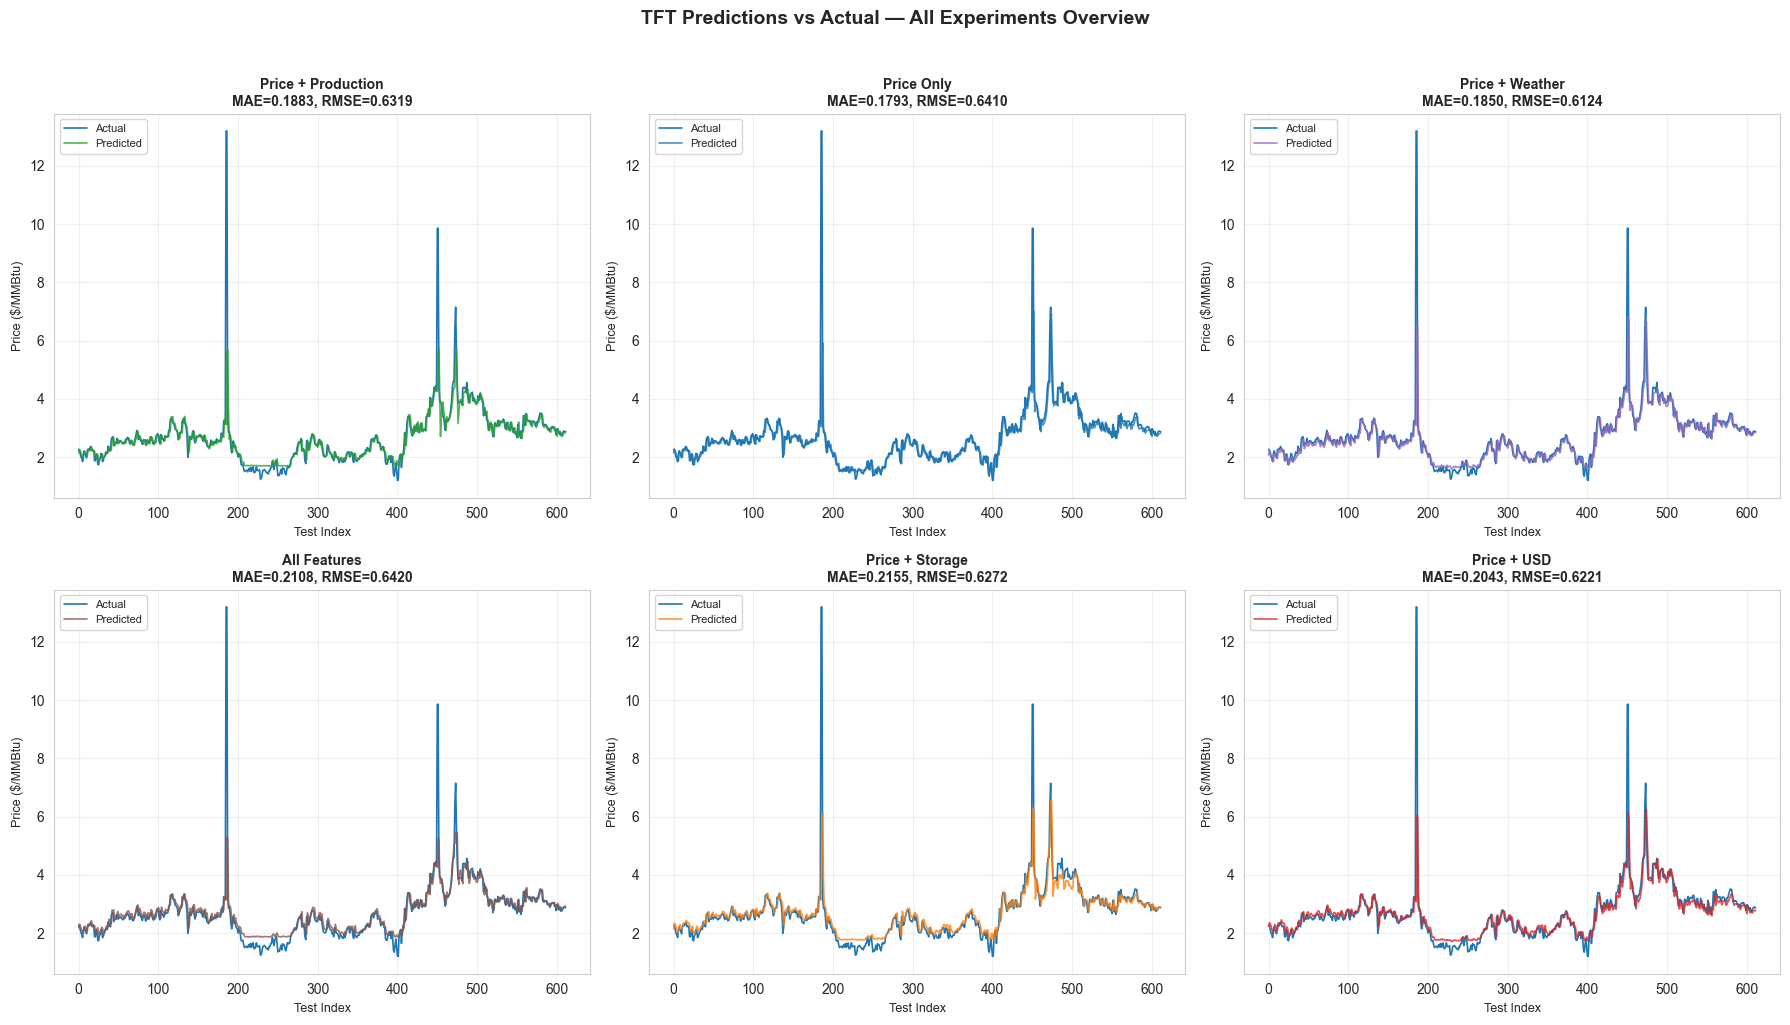


✅ Plotted predictions for 6 experiments
📁 Individual plots saved to: saved_results

PREDICTION METRICS SUMMARY


,Experiment,MAE,RMSE,MAPE (%),Dir. Acc (%)
0,Price + Production,0.1883,0.6319,6.13,43.5
1,Price Only,0.1793,0.6410,5.49,44.7
2,Price + Weather,0.1850,0.6124,5.96,45.0
3,All Features,0.2108,0.6420,7.63,44.0
4,Price + Storage,0.2155,0.6272,7.51,43.7
5,Price + USD,0.2043,0.6221,6.98,44.8


In [12]:
# === Cell 11: Load and Plot Predictions vs Actuals (LSTM-style format) ===

def get_experiment_filename(experiment_name: str) -> str:
    """Get filename-safe version of experiment name."""
    filename_map = {
        "Price Only": "price_only",
        "Price + Storage": "price_storage", 
        "Price + Production": "price_prod",
        "Price + USD": "price_usd",
        "Price + Weather": "price_weather",
        "All Features": "price_stor_prod_usd_weather"
    }
    return filename_map.get(experiment_name, experiment_name.lower().replace(" ", "_").replace("+", ""))

def plot_single_experiment_predictions(metrics_data: dict, experiment_name: str, save_dir: Path):
    """Plot predictions vs actuals for a single experiment (LSTM-style format)."""
    if experiment_name not in metrics_data:
        return None
    
    data = metrics_data[experiment_name]
    y_true = np.array(data.get('y_true', []))
    y_pred = np.array(data.get('y_pred_p50', []))
    
    if len(y_true) == 0 or len(y_pred) == 0:
        return None
    
    # Calculate metrics
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100
    
    # Directional accuracy
    true_dir = np.sign(np.diff(y_true))
    pred_dir = np.sign(np.diff(y_pred))
    da = (true_dir == pred_dir).mean() * 100
    
    # Create LSTM-style figure
    fig, ax = plt.subplots(figsize=(14, 6))
    
    x = np.arange(len(y_pred))
    
    # Plot actual and predicted (matching LSTM style)
    ax.plot(x, y_true, label='Actual Price', color='#1f77b4', linewidth=1.5, alpha=0.9)
    ax.plot(x, y_pred, label='TFT Predicted (P50)', color='#d62728', linewidth=1.5, alpha=0.8, linestyle='--')
    
    # Fill between for visual clarity
    ax.fill_between(x, y_true, y_pred, alpha=0.1, color='gray')
    
    ax.set_xlabel('Test Sample Index', fontsize=12)
    ax.set_ylabel('Henry Hub Price ($/MMBtu)', fontsize=12)
    ax.set_title(f'TFT Model: {experiment_name}\nPredicted vs Actual Henry Hub Natural Gas Prices', 
                 fontsize=14, fontweight='bold')
    
    # Add metrics box (LSTM style)
    metrics_text = f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}\nMAPE: {mape:.2f}%\nDir. Acc: {da:.1f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    # Save with experiment name in filename (LSTM convention)
    filename = f"tft_{get_experiment_filename(experiment_name)}_pred_vs_actual.png"
    filepath = save_dir / filename
    plt.savefig(filepath, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"   📊 Saved: {filename}")
    
    plt.show()
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'DA': da, 'filepath': filepath}

# Plot individual experiments with saved predictions
print("=" * 80)
print("TFT PREDICTION VS ACTUAL PLOTS (Individual per Experiment)")
print("=" * 80)

experiments_with_data = [name for name in experiment_data.keys() if name in final_metrics_data]
n_experiments = len(experiments_with_data)

all_metrics = {}

if n_experiments > 0:
    for name in experiments_with_data:
        print(f"\n📈 {name}:")
        result = plot_single_experiment_predictions(final_metrics_data, name, SAVED_RESULTS_DIR)
        if result:
            all_metrics[name] = result
    
    # Also create a combined overview plot
    print("\n" + "-" * 60)
    print("Creating combined overview plot...")
    
    n_rows = (n_experiments + 2) // 3
    n_cols = min(3, n_experiments)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), squeeze=False)
    axes = axes.flatten()
    
    for idx, name in enumerate(experiments_with_data):
        if idx < len(axes):
            ax = axes[idx]
            data = final_metrics_data[name]
            y_true = np.array(data.get('y_true', []))
            y_pred = np.array(data.get('y_pred_p50', []))
            
            if len(y_true) > 0 and len(y_pred) > 0:
                x = np.arange(len(y_pred))
                color = EXPERIMENT_COLORS.get(name, '#d62728')
                
                ax.plot(x, y_true, label='Actual', color='#1f77b4', linewidth=1.2)
                ax.plot(x, y_pred, label='Predicted', color=color, linewidth=1.2, alpha=0.8)
                
                # Calculate metrics for subtitle
                mae = np.mean(np.abs(y_true - y_pred))
                rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
                
                ax.set_title(f'{name}\nMAE={mae:.4f}, RMSE={rmse:.4f}', fontsize=10, fontweight='bold')
                ax.set_xlabel('Test Index', fontsize=9)
                ax.set_ylabel('Price ($/MMBtu)', fontsize=9)
                ax.legend(loc='upper left', fontsize=8)
                ax.grid(True, alpha=0.3)
    
    # Hide unused axes
    for idx in range(n_experiments, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('TFT Predictions vs Actual — All Experiments Overview', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(SAVED_RESULTS_DIR / 'tft_pred_vs_actual_all_experiments.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Plotted predictions for {n_experiments} experiments")
    print(f"📁 Individual plots saved to: {SAVED_RESULTS_DIR}")
else:
    print("⚠️ No prediction data available.")
    print("   Run the retraining cells above to generate predictions.")

# Summary table of prediction metrics
if all_metrics:
    print("\n" + "=" * 80)
    print("PREDICTION METRICS SUMMARY")
    print("=" * 80)
    
    metrics_table = []
    for name, metrics in all_metrics.items():
        metrics_table.append({
            'Experiment': name,
            'MAE': f"{metrics['MAE']:.4f}",
            'RMSE': f"{metrics['RMSE']:.4f}",
            'MAPE (%)': f"{metrics['MAPE']:.2f}",
            'Dir. Acc (%)': f"{metrics['DA']:.1f}"
        })
    
    metrics_df = pd.DataFrame(metrics_table)
    display(metrics_df)

# Show which experiments are still missing
experiments_without_data = [name for name in experiment_data.keys() if name not in final_metrics_data]
if experiments_without_data:
    print(f"\n⚠️ Still missing prediction data for {len(experiments_without_data)} experiments:")
    for name in experiments_without_data:
        print(f"   • {name}")

## 11. Correlation Analysis: Hyperparameters vs Performance

Analyze correlations between hyperparameters and model performance.

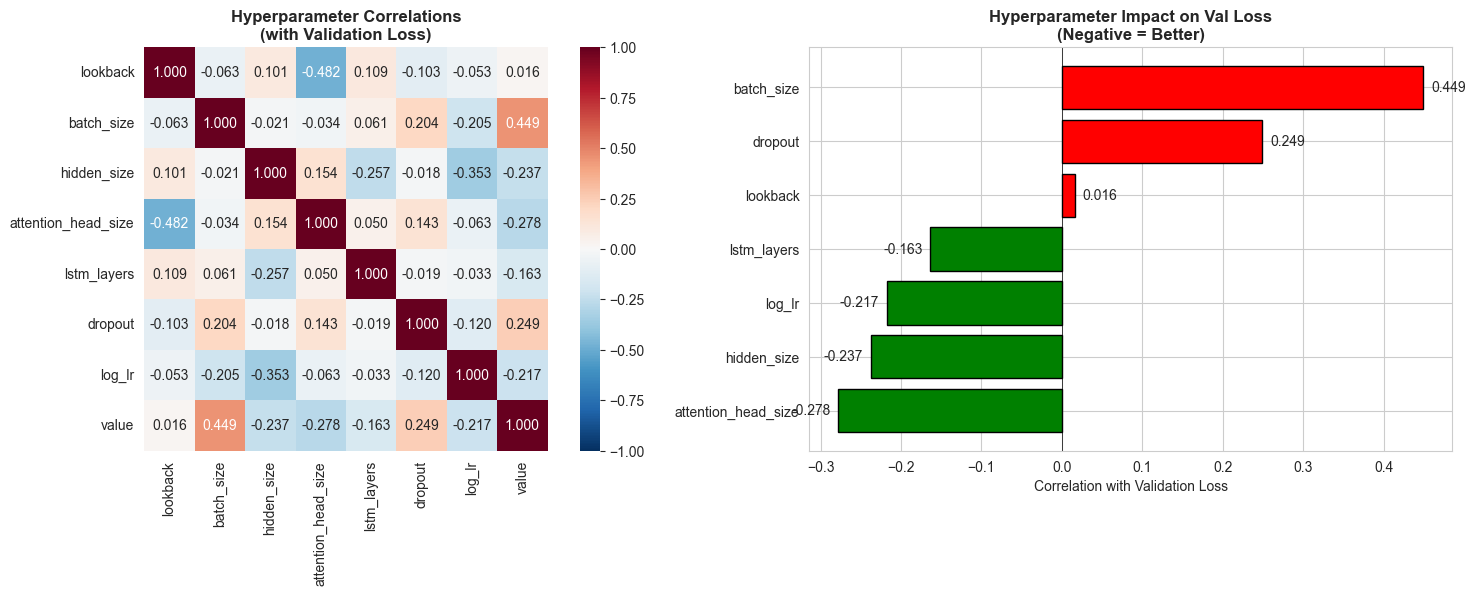


CORRELATION INTERPRETATION

📈 CORRELATION WITH VALIDATION LOSS:
   Negative correlation = Lower val loss (better performance)
   Positive correlation = Higher val loss (worse performance)
    
   attention_head_size : -0.278 → BENEFICIAL
   hidden_size         : -0.237 → BENEFICIAL
   log_lr              : -0.217 → BENEFICIAL
   lstm_layers         : -0.163 → BENEFICIAL
   lookback            : +0.016 → NEUTRAL
   dropout             : +0.249 → DETRIMENTAL
   batch_size          : +0.449 → DETRIMENTAL


In [13]:
# === Cell 12: Correlation Analysis ===

# Prepare data for correlation
corr_cols = ['lookback', 'batch_size', 'hidden_size', 'attention_head_size', 'lstm_layers', 'dropout', 'lr', 'value']
corr_data = combined_df[corr_cols].dropna()

if len(corr_data) > 10:
    # Add log learning rate for better correlation
    corr_data = corr_data.copy()
    corr_data['log_lr'] = np.log10(corr_data['lr'])
    
    # Compute correlation matrix
    analysis_cols = ['lookback', 'batch_size', 'hidden_size', 'attention_head_size', 'lstm_layers', 'dropout', 'log_lr', 'value']
    corr_matrix = corr_data[analysis_cols].corr()
    
    # Create heatmap
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Full correlation heatmap
    ax = axes[0]
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                square=True, ax=ax, vmin=-1, vmax=1)
    ax.set_title('Hyperparameter Correlations\n(with Validation Loss)', fontsize=12, fontweight='bold')
    
    # 2. Bar chart of correlations with val loss
    ax = axes[1]
    val_corr = corr_matrix['value'].drop('value').sort_values()
    colors = ['green' if c < 0 else 'red' for c in val_corr]
    ax.barh(val_corr.index, val_corr.values, color=colors, edgecolor='black')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Correlation with Validation Loss')
    ax.set_title('Hyperparameter Impact on Val Loss\n(Negative = Better)', fontsize=12, fontweight='bold')
    
    # Add value labels
    for i, (idx, val) in enumerate(val_corr.items()):
        ax.text(val + 0.01 if val >= 0 else val - 0.01, i, f'{val:.3f}', 
                va='center', ha='left' if val >= 0 else 'right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(SAVED_RESULTS_DIR / 'tft_correlations.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print interpretation
    print("\n" + "=" * 80)
    print("CORRELATION INTERPRETATION")
    print("=" * 80)
    print("""
📈 CORRELATION WITH VALIDATION LOSS:
   Negative correlation = Lower val loss (better performance)
   Positive correlation = Higher val loss (worse performance)
    """)
    
    for param, corr in val_corr.items():
        direction = "BENEFICIAL" if corr < -0.1 else "DETRIMENTAL" if corr > 0.1 else "NEUTRAL"
        print(f"   {param:20}: {corr:+.3f} → {direction}")
else:
    print("⚠️ Not enough data for correlation analysis (need at least 10 completed trials)")

## 12. Radar Chart: Multi-Metric Comparison

Visual comparison of all metrics across experiments using a radar/spider chart.

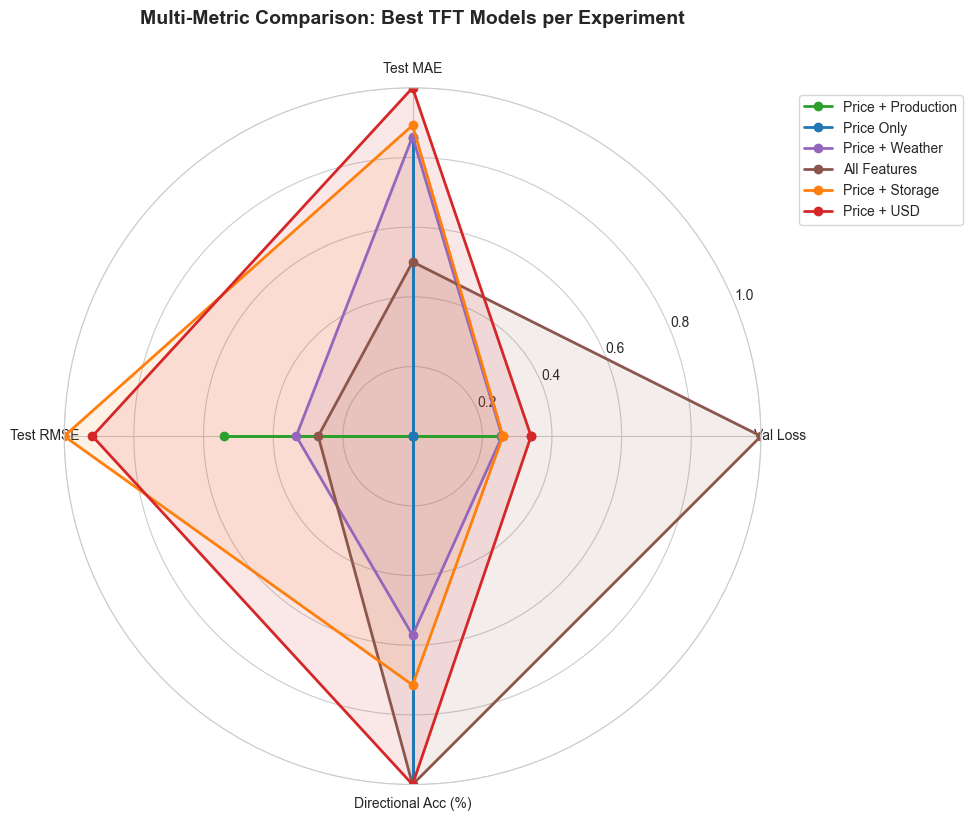

In [14]:
# === Cell 13: Radar Chart Multi-Metric Comparison ===

def create_radar_chart(df, metrics, title="Model Comparison"):
    """Create a radar chart comparing experiments across multiple metrics."""
    
    # Filter to available metrics
    radar_data = df[['Experiment'] + metrics].dropna().copy()
    
    if len(radar_data) == 0:
        print("No data available for radar chart")
        return
    
    # Normalize each metric to 0-1 scale
    for metric in metrics:
        col = radar_data[metric]
        min_val, max_val = col.min(), col.max()
        if max_val > min_val:
            # For error metrics, invert so higher = better
            if metric in ['Val Loss', 'Test MAE', 'Test RMSE', 'Test MAPE (%)']:
                radar_data[metric + '_norm'] = 1 - (col - min_val) / (max_val - min_val)
            else:
                radar_data[metric + '_norm'] = (col - min_val) / (max_val - min_val)
        else:
            radar_data[metric + '_norm'] = 0.5
    
    # Set up radar chart
    norm_metrics = [m + '_norm' for m in metrics]
    num_vars = len(metrics)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    for idx, row in radar_data.iterrows():
        values = [row[m] for m in norm_metrics]
        values += values[:1]
        
        color = EXPERIMENT_COLORS.get(row['Experiment'], '#333')
        ax.plot(angles, values, 'o-', linewidth=2, label=row['Experiment'], color=color)
        ax.fill(angles, values, alpha=0.1, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, size=10)
    ax.set_ylim(0, 1)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.title(title, size=14, fontweight='bold', y=1.08)
    plt.tight_layout()
    plt.savefig(SAVED_RESULTS_DIR / 'tft_radar_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Create radar chart if we have best model data
if len(best_df) > 0:
    radar_metrics = ['Val Loss', 'Test MAE', 'Test RMSE', 'Directional Acc (%)']
    available_metrics = [m for m in radar_metrics if m in best_df.columns and best_df[m].notna().any()]
    
    if len(available_metrics) >= 3:
        create_radar_chart(best_df, available_metrics, 
                          "Multi-Metric Comparison: Best TFT Models per Experiment")
    else:
        print(f"⚠️ Not enough metrics available for radar chart (have {len(available_metrics)}, need at least 3)")
        print(f"   Available: {available_metrics}")
else:
    print("⚠️ No best model data available for radar chart")

## 13. Final Summary & Recommendations

Key findings and recommended configurations based on all experiments.

In [15]:
# === Cell 14: Final Summary & Recommendations ===

print("=" * 80)
print("                    TFT HYPERPARAMETER TUNING SUMMARY")
print("=" * 80)

# Overall best model
all_best = []
for name, df in experiment_data.items():
    completed = df[df['state'] == 'COMPLETE'].copy()
    if len(completed) > 0:
        best_idx = completed['value'].idxmin()
        best = completed.loc[best_idx].copy()
        best['experiment'] = name
        all_best.append(best)

if len(all_best) > 0:
    all_best_df = pd.DataFrame(all_best)
    overall_best_idx = all_best_df['value'].idxmin()
    overall_best = all_best_df.loc[overall_best_idx]
    
    print(f"\n🏆 OVERALL BEST MODEL:")
    print(f"   Experiment: {overall_best['experiment']}")
    print(f"   Trial #: {int(overall_best['trial_number'])}")
    print(f"   Val Loss: {overall_best['value']:.6f}")
    if 'test_mae' in overall_best and pd.notna(overall_best['test_mae']):
        print(f"   Test MAE: {overall_best['test_mae']:.4f}")
    if 'test_rmse' in overall_best and pd.notna(overall_best['test_rmse']):
        print(f"   Test RMSE: {overall_best['test_rmse']:.4f}")

print("\n📊 KEY FINDINGS:")
print("-" * 60)

# Best lookback
if len(top_combined) > 0:
    best_lookback = top_combined.groupby('lookback')['value'].mean().idxmin()
    print(f"\n1. OPTIMAL LOOKBACK WINDOW: {int(best_lookback)} days")
    print(f"   - Most frequent in top models: {int(lookback_counts.idxmax())} days")
    
    # Best hidden size
    best_hidden = top_combined.groupby('hidden_size')['value'].mean().idxmin()
    print(f"\n2. OPTIMAL HIDDEN SIZE: {int(best_hidden)}")
    print(f"   - Most frequent in top models: {int(hidden_counts.idxmax())}")
    
    # Best layers
    best_layers = top_combined.groupby('lstm_layers')['value'].mean().idxmin()
    print(f"\n3. OPTIMAL LSTM LAYERS: {int(best_layers)} layer(s)")
    
    # Best attention heads
    best_attn = top_combined.groupby('attention_head_size')['value'].mean().idxmin()
    print(f"\n4. OPTIMAL ATTENTION HEADS: {int(best_attn)}")
    
    # Learning rate
    lr_median = top_combined['lr'].median()
    lr_range = (top_combined['lr'].quantile(0.25), top_combined['lr'].quantile(0.75))
    print(f"\n5. OPTIMAL LEARNING RATE RANGE:")
    print(f"   - Median: {lr_median:.6f}")
    print(f"   - IQR: [{lr_range[0]:.6f}, {lr_range[1]:.6f}]")

# Pruning efficiency
total_trials = sum(len(df) for df in experiment_data.values())
total_pruned = sum(len(df[df['state'] == 'PRUNED']) for df in experiment_data.values())
print(f"\n6. PRUNING EFFICIENCY:")
print(f"   - Total trials: {total_trials}")
print(f"   - Pruned trials: {total_pruned} ({total_pruned/total_trials*100:.1f}%)")
print(f"   - Computational savings: ~{total_pruned/total_trials*100:.0f}% of full training")

# Feature importance ranking (by best val loss)
print("\n7. FEATURE SET RANKING (by best val loss):")
if len(all_best_df) > 0:
    feature_ranking = all_best_df.sort_values('value')[['experiment', 'value']].reset_index(drop=True)
    for i, row in feature_ranking.iterrows():
        print(f"   {i+1}. {row['experiment']}: {row['value']:.6f}")

print("\n" + "=" * 80)
print("                         RECOMMENDED TFT CONFIGURATION")
print("=" * 80)

if len(top_combined) > 0:
    print(f"""
Based on the analysis of {total_trials} trials across {len(experiment_data)} experiments:

┌─────────────────────────────────────────────────────────────────┐
│  HYPERPARAMETER              │  RECOMMENDED VALUE              │
├─────────────────────────────────────────────────────────────────┤
│  Lookback (max_encoder_len)  │  {int(best_lookback)} days                         │
│  Hidden Size                 │  {int(best_hidden)}                               │
│  LSTM Layers                 │  {int(best_layers)}                                │
│  Attention Heads             │  {int(best_attn)}                                │
│  Learning Rate               │  {lr_median:.4f} ({lr_range[0]:.4f}-{lr_range[1]:.4f})    │
│  Early Stopping              │  Patience 8, monitor val_loss   │
└─────────────────────────────────────────────────────────────────┘
    """)

                    TFT HYPERPARAMETER TUNING SUMMARY

🏆 OVERALL BEST MODEL:
   Experiment: All Features
   Trial #: 230
   Val Loss: 0.204424
   Test MAE: 0.1894
   Test RMSE: 0.6232

📊 KEY FINDINGS:
------------------------------------------------------------

1. OPTIMAL LOOKBACK WINDOW: 20 days
   - Most frequent in top models: 30 days

2. OPTIMAL HIDDEN SIZE: 96
   - Most frequent in top models: 128

3. OPTIMAL LSTM LAYERS: 2 layer(s)

4. OPTIMAL ATTENTION HEADS: 1

5. OPTIMAL LEARNING RATE RANGE:
   - Median: 0.002120
   - IQR: [0.001717, 0.002724]

6. PRUNING EFFICIENCY:
   - Total trials: 1800
   - Pruned trials: 997 (55.4%)
   - Computational savings: ~55% of full training

7. FEATURE SET RANKING (by best val loss):
   1. All Features: 0.204424
   2. Price + USD: 0.231281
   3. Price + Storage: 0.234566
   4. Price + Weather: 0.234662
   5. Price + Production: 0.234777
   6. Price Only: 0.245121

                         RECOMMENDED TFT CONFIGURATION

Based on the analysis of 1

## 14. Export Summary Tables

Export all summary data to CSV files for use in thesis/reports.

In [16]:
# === Cell 15: Export Summary Tables ===

# Create output directory
OUTPUT_DIR = SAVED_RESULTS_DIR / "analysis_output"
OUTPUT_DIR.mkdir(exist_ok=True)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Export experiment summary
summary_file = OUTPUT_DIR / f"tft_experiment_summary_{timestamp}.csv"
summary_df.to_csv(summary_file, index=False)
print(f"✅ Saved: {summary_file}")

# 2. Export best model comparison
if len(best_df) > 0:
    best_file = OUTPUT_DIR / f"tft_best_models_comparison_{timestamp}.csv"
    best_df.to_csv(best_file, index=False)
    print(f"✅ Saved: {best_file}")

# 3. Export optimal parameter summary
if len(top_combined) > 0:
    optimal_params = {
        'Parameter': [
            'Lookback (max_encoder_length)', 
            'Hidden Size', 
            'LSTM Layers', 
            'Attention Heads',
            'Learning Rate (median)', 
            'Learning Rate (IQR low)', 
            'Learning Rate (IQR high)'
        ],
        'Optimal Value': [
            int(best_lookback) if 'best_lookback' in dir() else '-',
            int(best_hidden) if 'best_hidden' in dir() else '-',
            int(best_layers) if 'best_layers' in dir() else '-',
            int(best_attn) if 'best_attn' in dir() else '-',
            f"{lr_median:.6f}" if 'lr_median' in dir() else '-',
            f"{lr_range[0]:.6f}" if 'lr_range' in dir() else '-',
            f"{lr_range[1]:.6f}" if 'lr_range' in dir() else '-'
        ],
        'Notes': [
            'Most frequent in top models',
            'Size of hidden layers',
            'Number of LSTM layers in encoder',
            'Multi-head attention heads',
            'Center of optimal range',
            '25th percentile',
            '75th percentile'
        ]
    }
    optimal_df = pd.DataFrame(optimal_params)
    optimal_file = OUTPUT_DIR / f"tft_optimal_parameters_{timestamp}.csv"
    optimal_df.to_csv(optimal_file, index=False)
    print(f"✅ Saved: {optimal_file}")

# 4. Export pruning summary
pruning_data = []
for name, df in experiment_data.items():
    pruned = df[df['state'] == 'PRUNED']
    completed = df[df['state'] == 'COMPLETE']
    
    pruning_data.append({
        'Experiment': name,
        'Total Trials': len(df),
        'Completed': len(completed),
        'Pruned': len(pruned),
        'Pruning Rate (%)': round(len(pruned) / len(df) * 100, 1) if len(df) > 0 else 0
    })

pruning_df = pd.DataFrame(pruning_data)
pruning_file = OUTPUT_DIR / f"tft_pruning_summary_{timestamp}.csv"
pruning_df.to_csv(pruning_file, index=False)
print(f"✅ Saved: {pruning_file}")

# 5. Export convergence summary
if 'convergence_df' in dir():
    convergence_file = OUTPUT_DIR / f"tft_convergence_summary_{timestamp}.csv"
    convergence_df.to_csv(convergence_file, index=False)
    print(f"✅ Saved: {convergence_file}")

print(f"\n📁 All outputs saved to: {OUTPUT_DIR}")
print("\nFiles exported:")
for f in sorted(OUTPUT_DIR.glob(f"*{timestamp}*")):
    print(f"   - {f.name}")

✅ Saved: saved_results/analysis_output/tft_experiment_summary_20260115_120316.csv
✅ Saved: saved_results/analysis_output/tft_best_models_comparison_20260115_120316.csv
✅ Saved: saved_results/analysis_output/tft_optimal_parameters_20260115_120316.csv
✅ Saved: saved_results/analysis_output/tft_pruning_summary_20260115_120316.csv
✅ Saved: saved_results/analysis_output/tft_convergence_summary_20260115_120316.csv

📁 All outputs saved to: saved_results/analysis_output

Files exported:
   - tft_best_models_comparison_20260115_120316.csv
   - tft_convergence_summary_20260115_120316.csv
   - tft_experiment_summary_20260115_120316.csv
   - tft_optimal_parameters_20260115_120316.csv
   - tft_pruning_summary_20260115_120316.csv
